# O3 Air Pollution Predictive Modelling.

Imports

In [1]:
#data frame
import pandas as pd
import numpy as np

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib.dates as mdates

# machine laerning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_val_predict

# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer


from sklearn.impute import KNNImputer
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn import preprocessing
from scipy.stats import pearsonr, spearmanr



## Time series analysis

Reading in data

In [3]:
# Loading the dataset
df = pd.read_csv('merged_data_v2.csv', low_memory=False)

# Parse datetime
df['datetime'] = pd.to_datetime(df['datetime'], dayfirst=False)

# Extract useful time features
#df['hour'] = df['datetime'].dt.hour
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['dayofweek'] = df['datetime'].dt.dayofweek
df['year'] = df['datetime'].dt.year
# convert StationId to integer labels
df['stationid_int'], uniques = pd.factorize(df['StationId'])

df['Temperature'] = df['Temperature'] - 273

print(df.head(5))


# for one hot encoding stationid_int- was not successful
#one_hot_df = pd.get_dummies(df, columns = ['stationid_int'])
#one_hot_df['stationid_int'] = df['stationid_int'] 
#print(one_hot_df.head())

    datetime StationId                     StationName       City  \
0 2017-11-24     AP001  Secretariat, Amaravati - APPCB  Amaravati   
1 2017-11-25     AP001  Secretariat, Amaravati - APPCB  Amaravati   
2 2017-11-26     AP001  Secretariat, Amaravati - APPCB  Amaravati   
3 2017-11-27     AP001  Secretariat, Amaravati - APPCB  Amaravati   
4 2017-11-28     AP001  Secretariat, Amaravati - APPCB  Amaravati   

            State        lat        lon  Status  PM2.5    PM10  ...  Humidity  \
0  Andhra Pradesh  16.494222  80.510586  Active  71.36  115.75  ...  0.016259   
1  Andhra Pradesh  16.494222  80.510586  Active  81.40  124.50  ...  0.013991   
2  Andhra Pradesh  16.494222  80.510586  Active  78.32  129.06  ...  0.013252   
3  Andhra Pradesh  16.494222  80.510586  Active  88.76  135.32  ...  0.013289   
4  Andhra Pradesh  16.494222  80.510586  Active  64.18  104.09  ...  0.012934   

   Temperature  Windspeed          PSurf  Rainf  month  day  dayofweek  year  \
0    27.045052   1

Descriptive Stats

In [59]:
# Summary statistics for numeric variables
def summary_stats(df):

    # print nimber of stations
    print(f"Number of unique stations: {df['StationId'].nunique()}")
    
    print("Descriptive Statistics:")
    # for hour
    #df_desc = df.drop(['hour', 'month', 'dayofweek', 'datetime', 'lat', 'lon', 'day'], axis=1)

    df_desc = df.drop(['month', 'dayofweek', 'datetime', 'lat', 'lon', 'day'], axis=1)
    print(df_desc.describe())

    print("Missing Values:")
    print(df.isnull().sum())

#summary_stats(df)

In [60]:
def o3_stats(df):
    # Print O3 statistics
    print(f"\nO3 Statistics:")
    print(f"Mean O3: {df['O3'].mean():.2f}")
    print(f"Median O3: {df['O3'].median():.2f}")
    print(f"Min O3: {df['O3'].min():.2f}")
    print(f"Max O3: {df['O3'].max():.2f}")

#o3_stats(df)

Map visualsation

In [61]:
def map_vis(df):

    # Load Natural Earth countries (1:110m resolution)
    url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
    world = gpd.read_file(url)

    # Filter for India
    india = world[world["ADMIN"] == "India"]


    # grouping by city as hard to see individual points otherwise

    # groups by city and takes mean of O3 values
    df_mean = df.groupby(['City']).mean('O3').reset_index()
    # Remove rows with NaN values in or 'O3' columns
    df_clean = df_mean.dropna(subset=["O3"])

    gdf = gpd.GeoDataFrame(
        df_clean,  # remove NaNs
        geometry=gpd.points_from_xy(df_clean["lon"], df_clean["lat"]),
        crs="EPSG:4326"
    )

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(6, 4))
    india.plot(ax=ax, color="white", edgecolor="black")  # India boundary

    # Scatter plot of O3 levels
    gdf.plot(
        ax=ax,
        column="O3",        # pollutant column
        cmap="coolwarm",        # color scheme
        markersize=80,      # adjust dot size
        alpha=0.8,
        legend=True,
        legend_kwds={
        "label": "O₃ Concentration (µg/m³)",   # ← your legend label
        #"shrink": 0.6                         # optional: smaller colorbar
    }
    )

    plt.title("Map of Ozone (O₃) Levels Across India")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    plt.show()

#map_vis(df)

Visualising time series.

In [62]:
def ozone_time_series(df):
    
    # group by day (drop the time component)
    df_mean = (
        df.groupby(df['datetime'].dt.date)['O3']
        .mean()
        .reset_index()
    )

    # rename for clarity
    df_mean.columns = ['date', 'O3']

    # plot
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=df_mean, x='date', y='O3', alpha = 0.7)
    plt.title('Daily Mean Ozone (O₃) Levels Across India')
    plt.xlabel('Date')
    plt.ylabel('O₃ Concentration (µg/m³)')
    plt.tight_layout()
    plt.grid(alpha = 0.3)
    plt.show()


def all_pollutatants_time_series(df):

    pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']

    monthly_mean = (
    df.groupby(pd.Grouper(key='datetime', freq='D'))[pollutants]
      .mean()
      .reset_index()
    )

    # plot on different graphs for clarity

    plt.figure(figsize=(6, 4))
    for i, pollutant in enumerate(pollutants, 1):
        plt.subplot(3, 3, i)
        sns.lineplot(data=monthly_mean, x='datetime', y=pollutant)
        plt.title(f'Daily Mean {pollutant} Levels Across India')
        plt.xlabel('Date')
        plt.ylabel('Concentration (µg/m³)')
        plt.tight_layout()
    plt.show()
    

#ozone_time_series(df)
#all_pollutatants_time_series(df)

Random station ozone time series

In [63]:
def random_station_ozone_time_series(df):

    # select a random city
    random_station = df['StationId'].sample(n=1).values[0]

    df_station = df[df['StationId'] == random_station]

    # group by day (drop the time component)
    df_mean = (
        df_station.groupby(df_station['datetime'].dt.date)['O3']
        .mean()
        .reset_index()
    )

    # rename for clarity
    df_mean.columns = ['date', 'O3']

    # plot
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=df_mean, x='date', y='O3')

    plt.title(f'Daily Mean Ozone (O₃) Levels in {df_station["City"].values[0]} (Station {random_station})')
    plt.xlabel('Year')
    plt.ylabel('O₃ Concentration (µg/m³)')
    plt.grid(alpha=0.7)

    # Format x-axis to show only years
    ax = plt.gca()  # get current axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())  # one tick per year

    plt.tight_layout()
    plt.show()

# can return a city with no ozone data so may need to rerun to find one that does
#random_station_ozone_time_series(df)

Seasonal Trends

In [64]:
def yearly_fig(df):
    # Extract year from datetime
    # copy to not impact original df
    df_copy = df.copy()
    df_copy['Year'] = df_copy['datetime'].dt.year
    # # Year-over-Year O3 Trend
    yearly_O3 = df_copy.groupby('Year')['O3'].mean().reset_index()

    #print("\nYearly O3 Summary:")
    #print(yearly_O3)

    #plt.figure(figsize=(8, 6))
    plt.plot(yearly_O3['Year'], yearly_O3['O3'], marker='o', linewidth=2, 
             markersize=8, color='darkred')
    plt.title('Year-over-Year O3 Trend', fontsize=16, fontweight='bold')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Average O3', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(yearly_O3['Year'])
    plt.tight_layout()
    plt.show()

def monthly_fig(df):
    # Month-over-Month O3 Trend
    monthly_O3 = df.groupby('month')['O3'].mean().reset_index()

    #print("\nMonthly O3 Summary:")
    #print(monthly_O3)

    #plt.figure(figsize=(8, 6))
    plt.plot(monthly_O3['month'], monthly_O3['O3'], marker='o', linewidth=2, 
            markersize=8, color='darkred')
    plt.title('Month-over-Month O3 Trend', fontsize=16, fontweight='bold')
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Average O3', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(monthly_O3['month'])
    plt.tight_layout()
    plt.show()

def day_of_week_fig(df):
    # Day of the week O3 Trend
    day_of_week_O3 = df.groupby('dayofweek')['O3'].mean().reset_index()

    #print("\nDaily O3 Summary:")
    #print(day_of_week_O3)

    #plt.figure(figsize=(8, 6))
    plt.plot(day_of_week_O3['dayofweek'], day_of_week_O3['O3'], marker='o', linewidth=2, 
            markersize=8, color='lightgreen')
    plt.title('Day-Of-The-Week O3 Trend', fontsize=16, fontweight='bold')
    plt.xlabel('DayOfWeek', fontsize=12)
    plt.ylabel('Average O3', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(day_of_week_O3['dayofweek'])
    plt.tight_layout()
    plt.show()

def seasonal_trends(df):

    df_copy = df.copy()
    df_copy['weekday_name'] = df_copy['datetime'].dt.day_name()

    # Visualization
    plt.figure(figsize=(6,5))
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Autumn'

    df_copy['season'] = df_copy['month'].apply(get_season)

    seasonal_summary = df_copy.groupby('season')['O3'].mean().reset_index()
    sns.barplot(x='season', y='O3', data=seasonal_summary, order=['Spring', 'Summer', 'Autumn', 'Winter'])
    plt.title('Average Seasonal O₃ Levels')
    plt.show()

#seasonal_trends(df)
#yearly_fig(df)
#monthly_fig(df)
#day_of_week_fig(df)


Histograms

In [65]:
def histograms(df):
    numeric_features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']

    # Create subplots for all histograms
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()  # Make indexing easier

    for i, col in enumerate(numeric_features):
        sns.histplot(df[col], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].axvline(df[col].median(), color='r', linestyle='--', label='Median'),
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].legend()


    plt.tight_layout()
    plt.show()

#histograms(df)

Correlation matrix


Correlation with O3:
NO2            0.223971
SO2            0.134844
PM2.5          0.133021
NH3            0.126337
NOx            0.101440
PM10           0.044404
Temperature    0.031712
NO             0.019317
PSurf          0.016702
CO             0.009479
Name: O3, dtype: float64


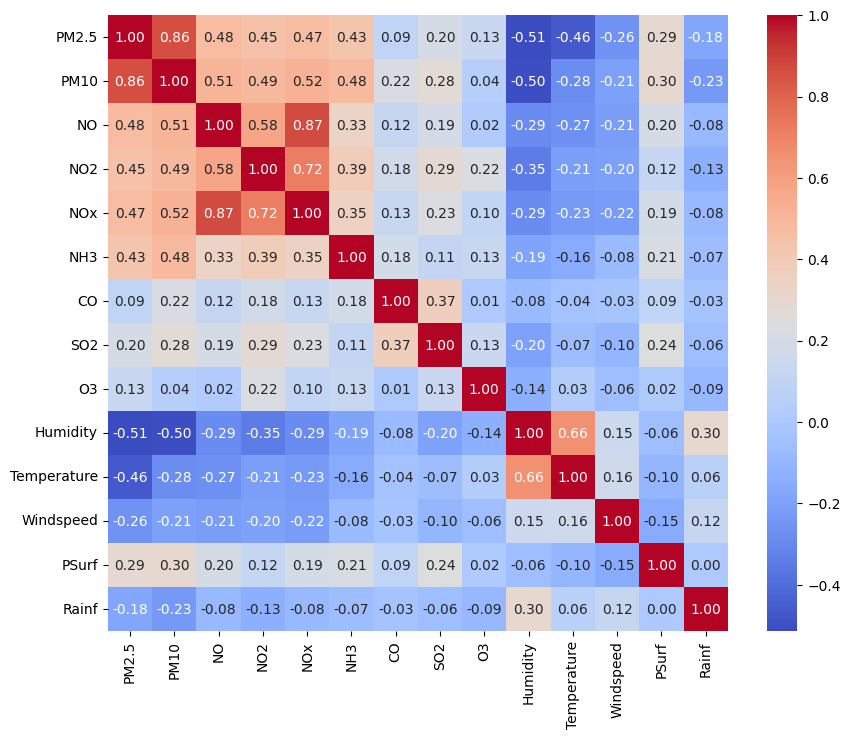

In [4]:
def correlation_matrix(df):

    # Correlation matrix for pollutants.
    df_corr = df.drop(['AQI_Bucket', 'City', 'datetime', 'StationId', 'StationName', 'Status', 'State', 'lat', 'lon', 'month', 'dayofweek', 'day', 'year', 'AQI', 'stationid_int'], axis=1)
    corr_matrix = df_corr.corr()

    # Show strong correlations with 03
    if 'O3' in corr_matrix.columns:
        O3_corr = corr_matrix['O3'].sort_values(ascending=False)
        print("\nCorrelation with O3:")
        print(O3_corr[1:11])

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')

correlation_matrix(df)

Covariance Matrix

In [67]:
def cov_matrix(df):

    # Correlation matrix for pollutants.
    df_cov = df.drop(['AQI_Bucket', 'City', 'datetime', 'StationId', 'StationName', 'Status', 'State'], axis=1)
    cov_matrix = df_cov.cov()

    plt.figure(figsize=(14, 10))
    sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap='coolwarm')

#cov_matrix(df)

Distribution of AQI

In [68]:
def aqi_plots(df):
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # 03 distribution
    axes[0].hist(df['AQI'].dropna(), bins=50, color='blue', edgecolor='black')
    axes[0].set_title('Distribution of AQI Values', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('AQI', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].axvline(df['AQI'].mean(), color='red', linestyle='--', label=f'Mean: {df["AQI"].mean():.2f}')
    axes[0].legend()

    # # AQI Bucket distribution
    aqi_bucket_counts = df['AQI_Bucket'].value_counts()
    axes[1].bar(aqi_bucket_counts.index, aqi_bucket_counts.values, color='red', edgecolor='black')
    axes[1].set_title('Distribution of AQI Buckets', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('AQI Bucket', fontsize=12)
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

#aqi_plots(df)

Top 50 Worst days for O3 pollution all in same place.

In [69]:
def top_pollutant_days(df, target_pollutant = 'O3'):

    df_copy = df.copy()
    df_copy['Year'] = df_copy['datetime'].dt.year
    # Get top 50 days with Highest O3
    top_O3_days = df_copy.nlargest(50, target_pollutant)[['datetime', 'StationName',target_pollutant]]

    print("=" * 50)
    print("Top 50 days with Highest O3")
    print("=" * 50)
    print(top_O3_days.to_string(index=False))

#top_pollutant_days(df, 'NO')

Average Pollutant per stations.

In [70]:
def avg_pollutant_by_station(df):

    # pollutant list
    pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene','Toluene','Xylene']

    stations_mean = (
        df.groupby('StationId')[pollutants]
          .mean()
          .reset_index()
    )

    # Stations by average pollutant levels

    # Create subplots: 3 rows × 3 columns
    fig, axes = plt.subplots(4, 3, figsize=(18, 12))
    axes = axes.flatten()  # make axes 1D for easy looping

    # Plot each pollutant
    for i, pollutant in enumerate(pollutants):
        # Sort stations for that pollutant
        sorted_data = stations_mean[pollutant].sort_values(ascending=False)

        sorted_data.plot(
            kind='barh',
            ax=axes[i],
            color='orange',
            edgecolor='black'
        )
        axes[i].set_title(f'Stations by Average {pollutant}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(f'Average {pollutant} (µg/m³)', fontsize=10)
        axes[i].set_ylabel('Station', fontsize=10)
        axes[i].tick_params(axis='y', labelsize=5)


    plt.tight_layout()
    plt.show()

#avg_pollutant_by_station(df)

Finding outliers in target variable

In [143]:
def find_outliers_in_avg_in_pollutant(df, target_pollutant = 'O3'):
  pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']
  stations_mean = (
      df.groupby('StationName')[pollutants]
        .mean()
        .reset_index()
  )
  top_stations = (
    stations_mean[['StationName', target_pollutant]]
    .sort_values(by=target_pollutant, ascending=False)
    .head(10)
  )
  print('Top stations', f'\n{top_stations}')

  bottom_stations = (
    stations_mean[['StationName', target_pollutant]]
    .sort_values(by=target_pollutant, ascending=True)
    .head(10)
  )
  print('Bottom Stations',  f'\n{bottom_stations}')

find_outliers_in_avg_in_pollutant(df, target_pollutant= 'NO')


Top stations 
                                           StationName          NO
81                            Samanpura, Patna - BSPCB  123.528737
3                            Anand Vihar, Delhi - DPCC   90.944519
72                                  Pusa, Delhi - DPCC   73.449290
106                        Vyttila, Kochi - Kerala PCB   71.771625
22                   DRM Office Danapur, Patna - BSPCB   65.212381
51    Major Dhyan Chand National Stadium, Delhi - DPCC   57.846386
74                             R K Puram, Delhi - DPCC   54.737957
19   Chhatrapati Shivaji Intl. Airport (T2), Mumbai...   53.526250
43              Jawaharlal Nehru Stadium, Delhi - DPCC   52.626073
40                                   ITO, Delhi - CPCB   50.976851
Bottom Stations 
                                    StationName        NO
50        Lumpyngngad, Shillong - Meghalaya PCB  0.917092
13  Bollaram Industrial Area, Hyderabad - TSPCB  2.964711
14                 Borivali East, Mumbai - MPCB  3.156865


Nan value analysis.

In [139]:
def nan_by_pollutant(df):

    India = df.copy()

    # Keep only pollutant-related columns
    polls = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','AQI']


    miss_pct = {}
    for c in polls:
        total_valid = India[c].notna().sum() + India[c].isna().sum()  
        miss_pct[c] = (India[c].isna().sum() / total_valid) * 100

    miss_pct = pd.Series(miss_pct).sort_values(ascending=False)
    print("Missing Percentage by Pollutant (%):", miss_pct)

    plt.figure(figsize=(6,5))
    sns.barplot(x=miss_pct.index, y=miss_pct.values, alpha = 0.7, width = 0.6)
    plt.title("Missing Percentage by Pollutant (%)", fontsize=14, fontweight='bold')
    plt.ylabel("Missing Percentage (%)")
    plt.xlabel("Pollutant")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def nan_by_city(df):

    India = df.copy()
    #--------------------------------------------------------------------------------------------------------------------------------
    # Calculate missing rate by city
    # Keep only pollutant-related columns
    polls = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','AQI']
    
    city_miss = India.groupby('City')[polls].apply(lambda x: x.isnull().mean() * 100)
    city_miss_mean = city_miss.mean(axis=1).sort_values(ascending=False)

    print("Top 10 Cities with Highest Missing Rates (%):")
    print(city_miss_mean.head(10))

    plt.figure(figsize=(12,6))
    city_miss_mean.plot(kind='bar', alpha = 0.7)
    plt.title("Average Missing Rate by City (%)")
    plt.ylabel("Missing Percentage (%)")
    plt.xlabel("City")
    plt.show()

    plt.figure(figsize=(8,6))
    sns.heatmap(
        city_miss,
        cmap='YlGnBu',       
        linewidths=0.3,       
        linecolor='white',
        cbar_kws={'label': 'Missing Rate (%)'},
        annot=True,             
        fmt=".1f",            
        annot_kws={'size':8, 'color':'black'} 
    )

    plt.title("City vs Pollutant Missing Rate Heatmap", fontsize=16, fontweight='bold', pad=12)
    plt.xlabel("Pollutant", fontsize=12)
    plt.ylabel("City", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(fontsize=9)
    plt.tight_layout()
    plt.show()

def nan_by_station(df):

    India = df.copy()
    #  Calculate missing rate by monitoring station

    polls = ['NO2', 'NO'] #['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','AQI']

    station_miss = India.groupby('stationid_int')[polls].apply(lambda x: x.isnull().mean() * 100)
    station_miss['Average'] = station_miss.mean(axis=1)
    station_miss = station_miss.sort_values('Average', ascending=False)

    print("Top 10 Monitoring Stations with Highest Missing Rates:")
    print(station_miss.head(10))

def nan_percent_by_station(df):

    # pollutant list
    pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']

    # Calculate % of NaN values for each pollutant per station
    stations_nan_pct = (
        df.groupby('StationId')[pollutants]
          .apply(lambda x: x.isna().mean() * 100)
          .reset_index()
    )

    # Create subplots: 3 rows × 3 columns
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    axes = axes.flatten()  # make axes 1D for easy looping

    # Plot each pollutant
    for i, pollutant in enumerate(pollutants):
        # Sort stations by % NaN for that pollutant
        sorted_data = stations_nan_pct.sort_values(by=pollutant, ascending=False)

        axes[i].barh(sorted_data['StationId'], sorted_data[pollutant],
                     color='skyblue', edgecolor='black')

        axes[i].set_title(f'% NaN in {pollutant}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('% Missing Values', fontsize=10)
        axes[i].set_ylabel('Station', fontsize=10)
        axes[i].tick_params(axis='y', labelsize=5)

    plt.tight_layout()
    plt.show()

#nan_by_pollutant(df)
#nan_by_city(df)
nan_by_station(df)
#nan_percent_by_station(df)

Top 10 Monitoring Stations with Highest Missing Rates:
                     NO2          NO    Average
stationid_int                                  
68             64.011946   64.111498  64.061722
58              7.317073  100.000000  53.658537
20             38.184160   60.141661  49.162910
17             47.486312   47.486312  47.486312
16             40.567446   40.617222  40.592334
7              40.837696   40.314136  40.575916
23             37.967115   37.967115  37.967115
4              35.537190   34.710744  35.123967
22             35.291190   34.295669  34.793430
3              34.920635   33.333333  34.126984


## Modelling

data set prep and splitting for modelling

In [10]:
def norm(df, X_feature_columns, target_pollutant = 'O3'):   
    """
    Function to normalise selected features in the dataframe.
    """
    # only normalise pollutant values
    col_to_norm = ['PM2.5','PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']
    col_to_norm.remove(target_pollutant)

    X = df[X_feature_columns]  # Can contain NaN values
    y = df[[target_pollutant]]  # Should not contain NaN
    # ------------------------------------------------------------------------------------------
    # Normalised dataset 
    X_norm = X.copy()
    # Scale only selected columns
    scaler_X = preprocessing.MinMaxScaler()
    X_norm[col_to_norm] = scaler_X.fit_transform(X[col_to_norm])
    scaler_y = preprocessing.MinMaxScaler()
    y_norm = scaler_y.fit_transform(y)

    y_norm_df = pd.DataFrame(y_norm, columns=[target_pollutant], index=y.index)

    df_norm = pd.concat([X_norm, y_norm_df], axis=1)

    return df_norm, scaler_y

def data_splitting(df, X_feature_columns, target_pollutant = 'O3'):

    df_split = df.copy()
    # get unique station names
    stations = df['stationid_int'].unique()
    # shuffle stations
    #np.random.seed(42)  # for reproducibility
    np.random.shuffle(stations)
    # split stations into train and test (80-20)
    split_index = int(0.8 * len(stations))
    train_stations = stations[:split_index]
    test_stations = stations[split_index:]
    # create train and test sets based on stations
    train_set = df_split[df_split['stationid_int'].isin(train_stations)]
    test_set = df_split[df_split['stationid_int'].isin(test_stations)]

    # split into X and y
    X_train, X_test = train_set[X_feature_columns], test_set[X_feature_columns]
    y_train, y_test = train_set[target_pollutant], test_set[target_pollutant]

    return X_train, X_test, y_train, y_test

def removing_outlier_in_target(df, target_pollutant):

    # Removing extreme outliers seen in avg_pollutant_per_station

    if target_pollutant == 'O3':
        
        df_no_outlier = df[df['StationName'] != 'Punjabi Bagh, Delhi - DPCC']

    elif target_pollutant == 'CO': 

        df_no_outlier = df[df['StationName'] != 'Maninagar, Ahmedabad - GPCB']

    elif target_pollutant == 'NO':

        df_no_outlier = df[df['StationName'] != 'Samanpura, Patna - BSPCB']

    elif target_pollutant == 'NOx':

        df_no_outlier = df[df['StationName'] != 'Anand Vihar, Delhi - DPCC']
        df_no_outlier = df_no_outlier[df_no_outlier['StationName'] != 'Samanpura, Patna - BSPCB']

    elif target_pollutant == 'SO2':

        df_no_outlier = df[df['StationName'] != 'Maninagar, Ahmedabad - GPCB']

    else:
        df_no_outlier = df

    return df_no_outlier

def preprocess(df, feature_columns, target_pollutant = 'O3', scaler = False):

    X_features = [col for col in feature_columns if col != target_pollutant]
    
    # Remove rows where target variable (O3) is missing
    df_no_Na = df.dropna(subset=[target_pollutant])

    df_clean = removing_outlier_in_target(df_no_Na, target_pollutant)

    if scaler == True:
        # normaise fatures
        df_norm, scaler_y = norm(df_clean, X_features, target_pollutant)
    else:
        df_norm = df_clean
        scaler_y = None

    # split data into train and test sets based on stations
    X_train, X_test, y_train, y_test = data_splitting(df_norm, X_features, target_pollutant)

    return X_train, X_test, y_train, y_test, scaler_y

def preprocess_subset(df, feature_columns, target_pollutant = 'O3', subset_size = 10, scaler = False):

    X_features = [col for col in feature_columns if col != target_pollutant]

    # Remove rows where target variable (O3) is missing
    df_no_Na = df.dropna(subset=[target_pollutant])

    df_clean = removing_outlier_in_target(df_no_Na, target_pollutant)

    if scaler == True:
        # normaise fatures
        df_norm, scaler_y = norm(df_clean, X_features, target_pollutant)

    else:
        df_norm = df_clean
        scaler_y = None

    # Get n random stations
    subset_stations = np.random.choice(df_norm['stationid_int'].unique(), size= subset_size, replace=False)

    # Filter
    subset_df = df_norm[df_norm['stationid_int'].isin(subset_stations)]

    # split data into train and test sets based on stations
    X_train, X_test, y_train, y_test = data_splitting(subset_df, X_features, target_pollutant)

    return X_train, X_test, y_train, y_test, scaler_y



In [5]:
#-----------------------------------------------------------------------------------------------
# features not using the station id
columns = df.columns.tolist()
cols_to_drop = ['lat', 'lon', 'State', 'City', 'StationId', 'Status', 'AQI', 'AQI_Bucket','dayofweek', 'StationName']
all_feature_columns = [c for c in columns if c not in cols_to_drop]

# target pollutant for testing
#target_pol = 'NOx'

# Change target polluatant if wanting to predict for different pollutant.
#X_train, X_test, y_train, y_test, scaler_y = preprocess(df, all_feature_columns, target_pollutant= target_pol, scaler = True)
#X_train_sub, X_test_sub, y_train_sub, y_test_sub, scaler_y = preprocess_subset(df, all_feature_columns, target_pollutant= target_pol)

#X_feature_columns = [f for f in all_feature_columns if f != target_pol]

random forest

In [6]:
def custom_rfecv_rf(X_train, y_train, protected_features= [], step=1, cv=5):

    """
    Custom RFECV that protects some features from elimination
    and stores feature importances at each step.
    
    Parameters:
    -----------
    estimator : sklearn estimator
    X_train : pd.DataFrame
    y_train : pd.Series or array
    protected_features : list of column names to never eliminate
    step : int, number of features to remove per iteration
    cv : int, cross-validation folds

    Returns:
    --------
    optimal_features : list of selected features
    """
    if protected_features is None:
        protected_features = []

    X_work = X_train.drop(columns=['stationid_int', 'datetime']).copy()
    features_remaining = list(X_work.columns)
    results = []
    vali_scores = []
    num_pollutants_list = []

    step_counter = 0

    while len([f for f in features_remaining if f not in protected_features]) >= step:

        num_pollutants_list.append(len([f for f in features_remaining if f not in protected_features]))
        
        print(f'Testing with {len([f for f in features_remaining if f not in protected_features])} pollutants as features')

        estimator = RandomForestRegressor(
            n_estimators=100,
            n_jobs=-1
        )

        # Compute CV score on current feature set
        y_pred = cross_val_predict(estimator, X_work[features_remaining], y_train, cv=cv)
        mse = mean_squared_error(y_train, y_pred)
        vali_scores.append(mse)
        
        # Fit estimator
        estimator.fit(X_work[features_remaining], y_train)

        # get importances
        importances = estimator.feature_importances_

        # Store results
        imp_df = pd.DataFrame({
            'feature': features_remaining,
            'importance': importances,
        }).sort_values('importance', ascending=False)
        
        results.append({
            'remaining_features': features_remaining.copy(),
            'importances': imp_df
        })

        # Identify candidates for elimination
        candidates = [f for f in features_remaining if f not in protected_features]
        n_remove = min(step, len(candidates))
        lowest_features = imp_df[imp_df['feature'].isin(candidates)].tail(n_remove)['feature'].tolist()

        # Remove lowest importance features
        for f in lowest_features:
            features_remaining.remove(f)

        # Optional: stop when number of features = number of protected features
        if len([f for f in features_remaining if f not in protected_features]) <= 0:
            break

    best_performance = min(vali_scores)
    best_idx = vali_scores.index(min(vali_scores))
    best_num_features = num_pollutants_list[best_idx]

    print(f"Optimal number of pollutants as features {best_num_features} with mse: {best_performance}")

    history_df = pd.concat([step['importances'].assign(step=i) for i, step in enumerate(results)], ignore_index=True)

    # Extract features from history_df at the best step
    optimal_step_df = history_df[history_df["step"] == best_idx]
    optimal_features = optimal_step_df["feature"].tolist()

    print(f"Optimal features: {optimal_features}")

    plt.plot(num_pollutants_list, vali_scores, marker='o')
    plt.xlabel("Number of pollutant features")
    plt.ylabel("Validation MSE")
    plt.title("RFECV Elimination Curve (Random Forest)")
    plt.grid(True)
    plt.savefig('')
    plt.show()

    return optimal_features


In [81]:
#protected = ['month', 'day', 'year']  # features to protect
#optimal_features_rf = custom_rfecv_rf(X_train, y_train, protected_features=protected,step=1,cv=5)


In [7]:
def random_forest_grid_search(X_train, X_test, y_train, y_test):

    param_grid = {
    'n_estimators' : [100], 
    'max_features': [0.6,0.8, 1],
    'max_samples': [0.6, 0.8, 1],
    'max_depth': [None],
    'ccp_alpha': [0],
    'min_samples_leaf': [1, 5]
    }

    grid = GridSearchCV(
        estimator=RandomForestRegressor(n_estimators=100, random_state=1),
        param_grid=param_grid,
        cv=5,
        scoring = 'neg_mean_squared_error',
        n_jobs=-1,
        return_train_score=True,
        verbose =2,
    )

    grid.fit(X_train.drop(columns=['stationid_int', 'datetime']), y_train)

    print("Best Parameters:", grid.best_params_)
    print("Best Score:", -grid.best_score_)

    return grid.best_params_, grid.best_estimator_


In [83]:
#best_params_rf, best_model_rf = random_forest_grid_search(X_train_sub, X_test_sub, y_train_sub, y_test_sub)

In [13]:
def random_forest(X_train, X_test, y_train, y_test, regr= None, feature_columns = None, print_res = True, plot_graphs = True, target_pollutant = 'O3'):


    if feature_columns is not None:
        X_train = X_train[feature_columns]
        X_test = X_test[feature_columns]

    # Then create and fit model ONLY on training data
    if regr == None:

        regr = RandomForestRegressor(
            n_estimators=100,
            random_state= 42,
            n_jobs= -1
        )

        regr.fit(X_train.drop(columns=['stationid_int', 'datetime']), y_train.drop(columns=['stationid_int']))

    # Predictions
    y_train_pred = regr.predict(X_train.drop(columns=['stationid_int', 'datetime']))
    y_test_pred = regr.predict(X_test.drop(columns=['stationid_int', 'datetime']))

    # Evaluation
    def evaluate(y_true, y_pred, print_result, dataset_type="Test"):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        nrmse = rmse / y_true.mean()  
        
        # --- Correlations ---
        pearson_r, _ = pearsonr(y_true, y_pred)
        spearman_r, _ = spearmanr(y_true, y_pred)

        if print_result == True:
            print(f"{dataset_type} MAE: {mae:.2f}")
            print(f"{dataset_type} MSE: {mse:.2f}")
            print(f"{dataset_type} RMSE: {rmse:.2f}")
            print(f"{dataset_type} R²: {r2:.2f}")
            print(f"{dataset_type} NRMSE: {nrmse:.2f}")
            print(f"{dataset_type} Person Corr: {pearson_r:.2f}")
            print(f"{dataset_type} Spearman Corr: {spearman_r:.2f}")
            
        return r2, rmse, nrmse, pearson_r, spearman_r

    r2_train, rmse_train, nrmse_train, pearson_train, spearman_train = evaluate(y_train, y_train_pred, print_res, "Train")
    r2_test, rmse_test, nrmse_test, pearson_test, spearman_test = evaluate(y_test, y_test_pred, print_res, "Test")

    def plotting():

        # Feature Importance
        importances = regr.feature_importances_
        feature_names = X_train.drop(columns=['stationid_int', 'datetime']).columns
        feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
        # plot feature importances
        plt.figure(figsize=(10, 6))
        sns.barplot(x=feature_importances, y=feature_importances.index)
        plt.title('Feature Importances from Random Forest')
        plt.xlabel('Importance Score')
        plt.ylabel('Features')
        plt.tight_layout()
        plt.show()
        
        random_station = np.random.choice(X_test['stationid_int'].unique())


        mask = X_test['stationid_int'] == random_station
        X_test_station = X_test[mask]
        y_test_station = y_test[mask.values]
        y_pred_station = y_test_pred[mask.values]

        plt.figure(figsize=(8, 5))
        plt.plot(X_test_station['datetime'][-100:], y_test_station[-100:], label=f'Station = {random_station} Actual {target_pollutant}',  alpha=0.7)
        plt.plot(X_test_station['datetime'][-100:], y_pred_station[-100:], label=f'Station = {random_station} Predicted {target_pollutant}', alpha=0.7)
        plt.xlabel("Date")
        plt.ylabel(f"{target_pollutant} Levels")
        plt.grid(alpha=0.3)
        plt.legend()
        plt.show()

          # Combine everything into one DataFrame for convenience
        df_results = pd.DataFrame({
            'stationid_int': X_test['stationid_int'].values,
            'y_true': y_test,
            'y_pred': y_test_pred
        })

        # Compute R² for each station
        station_r2 = (
            df_results.groupby('stationid_int', group_keys=False)
            .apply(lambda g: r2_score(g['y_true'], g['y_pred']), include_groups=False)
        )

        # Print top/bottom performing stations
        print("Top 5 stations by R²:")
        print(station_r2.sort_values(ascending=False).head())
        print("\nBottom 5 stations by R²:")
        print(station_r2.sort_values().head())

        plt.figure(figsize=(9, 5))
        n, bins, patches = plt.hist(
            station_r2, bins=8, color='#4C72B0', edgecolor='white', alpha=0.8, rwidth=0.9
        )

        plt.axvline(r2_test, color='red', linestyle='--', linewidth=2, label=f'Overall = {r2_test:.2f}')

        # Titles and labels
        plt.title("Distribution of Station-wise R² Scores", fontsize=14, weight='bold', pad=15)
        plt.xlabel("R² Score", fontsize=12)
        plt.ylabel("Number of Stations", fontsize=12)

        # Grid styling
        plt.grid(axis='y', linestyle='--', alpha=0.5)

        # Legend and layout
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Residual Analysis
        residuals = y_test - y_test_pred
        plt.figure(figsize=(10, 5))
        sns.histplot(residuals, kde=True)
        plt.title('Residual Distribution')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

        # plotting tree
        tree_to_plot = regr.estimators_[0]

        plt.figure(figsize=(20, 10))
        plot_tree(tree_to_plot, max_depth = 3, feature_names=X_train.columns.tolist(), filled=True, rounded=True, fontsize=10)
        plt.title("Decision Tree from Random Forest")
        plt.show()

    if plot_graphs == True:
        plotting()

    return regr, y_test_pred, r2_test, rmse_test, nrmse_test, pearson_test, spearman_test

In [11]:
target_pol = 'O3'
X_feature_columns = [f for f in all_feature_columns if f != target_pol]
X_train, X_test, y_train, y_test, scaler_y = preprocess(df, all_feature_columns, target_pollutant= target_pol)
model = random_forest(X_train, X_test, y_train, y_test, feature_columns= X_feature_columns, target_pollutant = 'O3')

Train MAE: 3.63
Train MSE: 28.08
Train RMSE: 5.30
Train R²: 0.94
Train NRMSE: 0.15
Train Person Corr: 0.98
Train Spearman Corr: 0.98
Test MAE: 15.72
Test MSE: 418.48
Test RMSE: 20.46
Test R²: 0.21
Test NRMSE: 0.58
Test Person Corr: 0.46
Test Spearman Corr: 0.47


ValueError: Length of values (16) does not match length of index (17)

xgboost

In [ ]:
def custom_rfecv_xgb(X_train, y_train, X_features, protected_features= [], target_pollutant = 'O3', step=1, cv=5):

    """
    Custom RFECV that protects some features from elimination
    and stores feature importances at each step.
    
    Parameters:
    -----------
    estimator : sklearn estimator
    X_train : pd.DataFrame
    y_train : pd.Series or array
    protected_features : list of column names to never eliminate
    step : int, number of features to remove per iteration
    cv : int, cross-validation folds

    Returns:
    --------
    optimal_features : list of selected features
    """

    # Creating validation set for perutaition importances
    train_df = pd.concat([X_train, y_train], axis=1)

    X_train_split, X_val_split, y_train_split, y_val_split = data_splitting(train_df, X_features, target_pollutant)

    if protected_features is None:
        protected_features = []

    X_work = X_train_split.drop(columns=['stationid_int', 'datetime']).copy()
    X_work_val = X_val_split.drop(columns=['stationid_int', 'datetime']).copy()
    features_remaining = list(X_work.columns)
    results = []
    vali_scores = []
    num_pollutants_list = []

    step_counter = 0

    while len([f for f in features_remaining if f not in protected_features]) >= step:

        num_pollutants_list.append(len([f for f in features_remaining if f not in protected_features]))
        
        print(f'Testing with {len([f for f in features_remaining if f not in protected_features])} pollutants as features')

        estimator = HistGradientBoostingRegressor(
            random_state=42,
            early_stopping = True,
            n_iter_no_change = 10,
            max_iter = 1000)
            
        # Compute CV score on current feature set
        y_pred = cross_val_predict(estimator, X_work[features_remaining], y_train_split, cv=cv)
        mse = mean_squared_error(y_train_split, y_pred)
        vali_scores.append(mse)
        
        # Fit estimator
        estimator.fit(X_work[features_remaining], y_train_split)

        # Calculate permutation importance on test set
        perm_importance = permutation_importance(estimator, X_work_val[features_remaining], y_val_split, random_state=42, n_repeats=5)

        importances = pd.DataFrame({
                'feature': features_remaining,
                'importance': perm_importance.importances_mean
            }).sort_values('importance', ascending=False)


        results.append({
            'remaining_features': features_remaining.copy(),
            'importances': importances
        })

        # Identify candidates for elimination
        candidates = [f for f in features_remaining if f not in protected_features]
        n_remove = min(step, len(candidates))
        lowest_features = importances[importances['feature'].isin(candidates)].tail(n_remove)['feature'].tolist()

        # Remove lowest importance features
        for f in lowest_features:
            features_remaining.remove(f)

        # Optional: stop when number of features = number of protected features
        if len([f for f in features_remaining if f not in protected_features]) <= 0:
            break

    best_performance = min(vali_scores)
    best_idx = vali_scores.index(min(vali_scores))
    best_num_features = num_pollutants_list[best_idx]

    print(f"Optimal number of pollutants as features {best_num_features} with mse: {best_performance}")

    history_df = pd.concat([step['importances'].assign(step=i) for i, step in enumerate(results)], ignore_index=True)

    # Extract features from history_df at the best step
    optimal_step_df = history_df[history_df["step"] == best_idx]
    optimal_features = optimal_step_df["feature"].tolist()

    print(f"Optimal features: {optimal_features}")

    plt.plot(num_pollutants_list, vali_scores, marker='o')
    plt.xlabel("Number of pollutant features")
    plt.ylabel("Validation MSE")
    plt.title("RFECV Elimination Curve (Hist XGBoost)")
    plt.grid(True)
    plt.show()

    return optimal_features

In [88]:
#optimal_features_xgb = custom_rfecv_xgb( X_train_sub, y_train_sub, X_feature_columns,step=1,cv=5)


In [89]:
#print(selected, ranked)
# top 5 features
#hxb_important = ranked['Feature'].head(9).tolist()
#print(hxb_important)

In [ ]:
def xgb_grid_search(X_train, X_test, y_train, y_test):

    param_grid = {
    'max_leaf_nodes' : [31], 
    'max_features': [0.6, 0.8, 1.0],
    'max_depth': [10, 25, None],
    'learning_rate' : [0.05, 0.01]
    }

    grid = GridSearchCV(
        estimator= HistGradientBoostingRegressor(max_iter=1000, random_state=42),
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose =3,
    )

    grid.fit(X_train.drop(columns=['stationid_int', 'datetime']), y_train)

    print("Best Parameters:", grid.best_params_)
    print("Best Score:", -grid.best_score_)

    return grid.best_params_, grid.best_estimator_


In [91]:
#best_params_xgb, best_model_xgb = xgb_grid_search(X_train_sub, X_test_sub, y_train_sub, y_test_sub)

Plateu of performance after 9 features.

In [16]:
def hxg_boost(X_train, X_test, y_train, y_test, selected_features = None, print_res = True, plot_graphs = True, optim_model = None, target_pollutant = 'O3'):

    if selected_features is not None:
        X_train = X_train[selected_features]
        X_test = X_test[selected_features]

    if model == None:
        # Then create and fit model ONLY on training data
        model = HistGradientBoostingRegressor(
            random_state=42,
            early_stopping = True,
            n_iter_no_change = 100,
            max_iter = 5000
        )

        # Fit directly with NaN values
        model.fit(X_train.drop(columns=['stationid_int', 'datetime']), y_train)

    else: 

        model = HistGradientBoostingRegressor(
        **{**optim_model.get_params(), "max_iter": 5000})

    y_pred = model.predict(X_test.drop(columns=['stationid_int', 'datetime']))
    

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    nrmse = rmse/ y_test.mean()
    # --- Correlations ---
    pearson_r, _ = pearsonr(y_test, y_pred)
    spearman_r, _ = spearmanr(y_test, y_pred)

    if print_res == True:
        print(f'R²: {r2:.3f}')
        print(f'RMSE: {rmse:.3f}')
        print(f'NRMSE: {nrmse:.3f}')
        print(f'MAE: {mae:.3f}')
        print(f'Pearson Corr: {pearson_r:.3f}')
        print(f'Spearman Corr: {spearman_r:.3f}')


    def plotting():

        # --- 4️⃣ Extract training and validation scores ---
        train_scores = -np.array(model.train_score_)  # convert from neg MSE to positive MSE
        val_scores = -np.array(model.validation_score_) if model.validation_score_ is not None else None

        # --- 5️⃣ Plot learning curves ---
        plt.figure(figsize=(8, 5))
        plt.plot(train_scores, label="Training MSE", marker='o', alpha=0.7)
        if val_scores is not None:
            plt.plot(val_scores, label="Validation MSE", marker='s', alpha=0.7)
        plt.xlabel("Boosting Iterations")
        plt.ylabel("Mean Squared Error")
        plt.title("HistGradientBoostingRegressor Learning Curves")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Combine everything into one DataFrame for convenience
        df_results = pd.DataFrame({
            'stationid_int': X_test['stationid_int'].values,
            'y_true': y_test,
            'y_pred': y_pred
        })

        # Compute R² for each station
        station_r2 = (
            df_results.groupby('stationid_int', group_keys=False)
            .apply(lambda g: r2_score(g['y_true'], g['y_pred']), include_groups=False)
        )

        # Print top/bottom performing stations
        print("Top 5 stations by R²:")
        print(station_r2.sort_values(ascending=False).head())
        print("\nBottom 5 stations by R²:")
        print(station_r2.sort_values().head())

        plt.figure(figsize=(9, 5))
        n, bins, patches = plt.hist(
            station_r2, bins=8, color='#4C72B0', edgecolor='white', alpha=0.8, rwidth=0.9
        )

        plt.axvline(r2, color='red', linestyle='--', linewidth=2, label=f'Overall = {r2:.2f}')

        # Titles and labels
        plt.title("Distribution of Station-wise R² Scores", fontsize=14, weight='bold', pad=15)
        plt.xlabel("R² Score", fontsize=12)
        plt.ylabel("Number of Stations", fontsize=12)

        # Grid styling
        plt.grid(axis='y', linestyle='--', alpha=0.5)

        # Legend and layout
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        random_station = np.random.choice(X_test['stationid_int'].unique())

        mask = X_test['stationid_int'] == random_station
        X_test_station = X_test.loc[mask]
        y_test_station = y_test[mask.values]
        y_pred_station = y_pred[mask.values]

        plt.figure(figsize=(8, 5))
        plt.plot(X_test_station['datetime'][-100:], y_test_station[-100:], label=f'Station = {random_station} Actual {target_pollutant}',  alpha=0.7)
        plt.plot(X_test_station['datetime'][-100:], y_pred_station[-100:], label=f'Station = {random_station} Predicted {target_pollutant}', alpha=0.7)
        plt.xlabel("Date")
        plt.ylabel(f"{target_pollutant} Levels")
        plt.grid(alpha=0.3)
        plt.legend()
        plt.show()

        # Calculate permutation importance on test set
        perm_importance = permutation_importance(model, X_test.drop(columns=['stationid_int', 'datetime']), y_test, random_state=42, n_repeats=5)
        importances = pd.Series(perm_importance.importances_mean, index=X_train.drop(columns=['stationid_int', 'datetime']).columns).sort_values(ascending=False)

        print("\nPermutation Feature Importances:")
        print(importances)

        plt.figure(figsize=(10,6))
        sns.barplot(x=importances.values, y=importances.index)
        plt.title(f'Permutation Feature Importance for {target_pollutant} Prediction')
        plt.xlabel('Importance Score (Decrease in R² when shuffled)')
        plt.ylabel('Feature')
        plt.show()

        # Residual plot
        residuals = y_test - y_pred
        plt.figure(figsize=(8,6))
        sns.histplot(residuals, kde=True)
        plt.title('Residual Distribution')
        plt.show()

    if plot_graphs == True:
        plotting()

    return model, y_pred, r2, rmse, nrmse, pearson_r, spearman_r


R²: 0.795
RMSE: 20.581
NRMSE: 0.471
MAE: 9.906
Pearson Corr: 0.900
Spearman Corr: 0.863


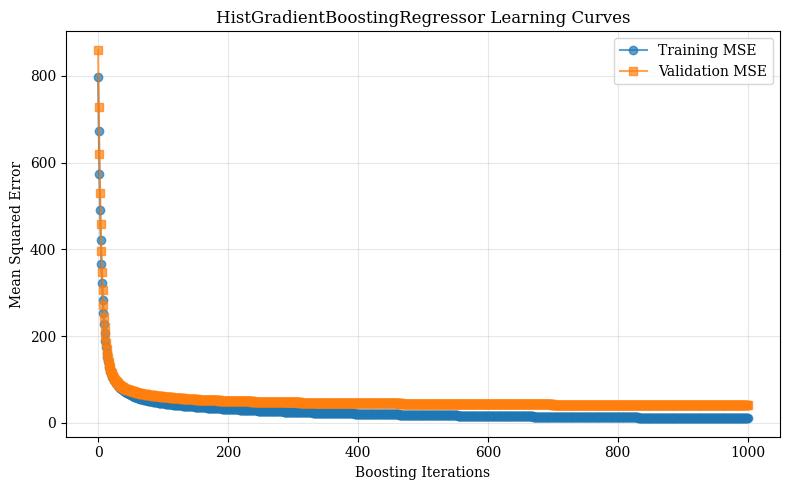

Top 5 stations by R²:
stationid_int
77     0.968679
106    0.963886
27     0.963048
60     0.949428
74     0.947340
dtype: float64

Bottom 5 stations by R²:
stationid_int
3    -0.796838
68   -0.299023
69    0.351793
4     0.512772
84    0.580086
dtype: float64


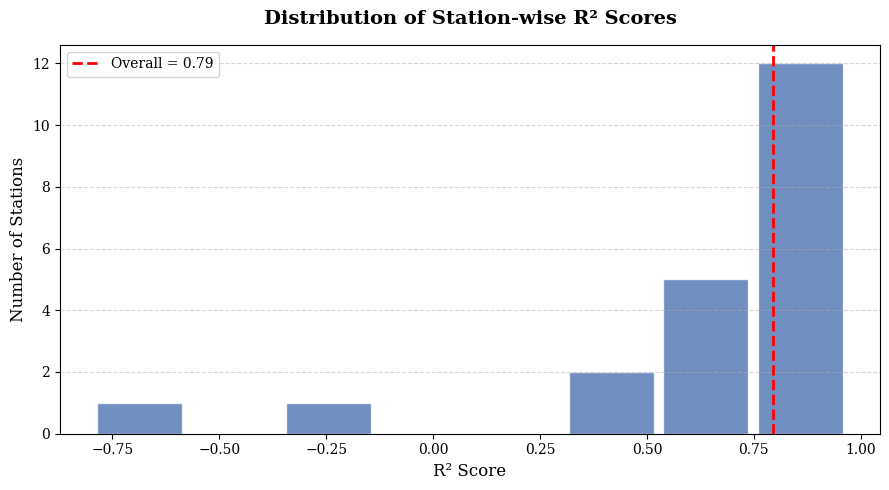

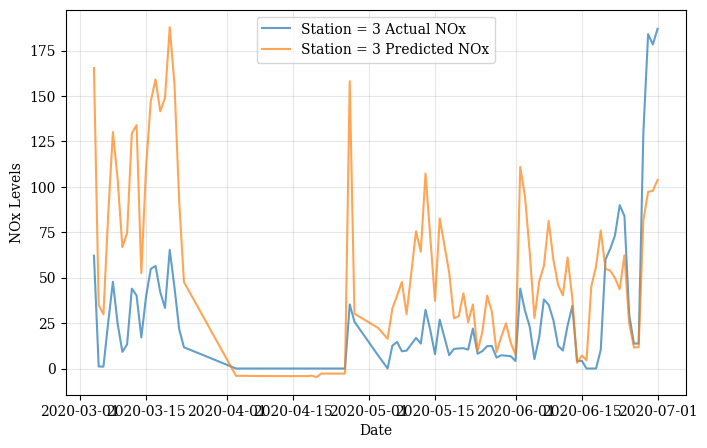


Permutation Feature Importances:
NO         0.648921
NO2        0.247477
year       0.053370
PM10       0.029227
month      0.018043
NH3        0.010864
PM2.5      0.010763
Toluene    0.010402
day        0.005907
CO         0.005386
SO2        0.003431
Benzene    0.002201
O3        -0.000132
Xylene    -0.000692
dtype: float64


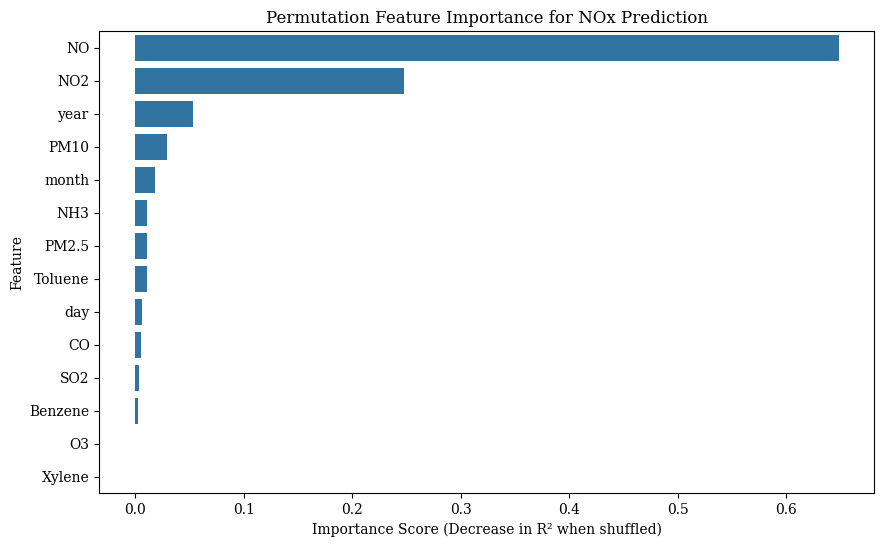

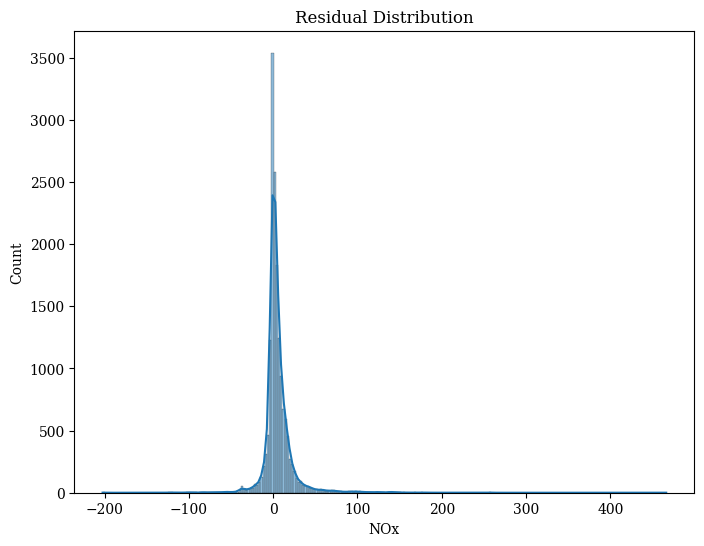

In [93]:
# Change target polluatant if wanting to predict for different pollutant.
X_train, X_test, y_train, y_test, scaler_y = preprocess(df, all_feature_columns, target_pollutant= 'NOx', scaler = False)
X_feature_columns = [f for f in all_feature_columns if f != 'NOx']
xgb = hxg_boost(X_train, X_test, y_train, y_test, selected_features = X_feature_columns, target_pollutant = 'NOx')

Voting Regressor

In [12]:
def voting_reg(X_test_rf, X_test_xgb, y_test, rf_model, xgb_model, print_res = True):

    # Get predictions from both models
    y_pred_rf = rf_model.predict(X_test_rf.drop(columns=['stationid_int', 'datetime']))
    y_pred_xgb = xgb_model.predict(X_test_xgb.drop(columns=['stationid_int', 'datetime']))

    # Simple unweighted average (equal voting)
    y_pred = (y_pred_rf + y_pred_xgb) / 2
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    nrmse = rmse/ y_test.mean()
    # --- Correlations ---
    pearson_r, _ = pearsonr(y_test, y_pred)
    spearman_r, _ = spearmanr(y_test, y_pred)

    if print_res == True:
        print(f'R²: {r2:.3f}')
        print(f'RMSE: {rmse:.3f}')
        print(f'NRMSE: {nrmse:.3f}')
        print(f'MAE: {mae:.3f}')
        print(f'Pearson Corr: {pearson_r:.3f}')
        print(f'Spearman Corr: {spearman_r:.3f}')

    return y_pred, r2, rmse, nrmse, pearson_r, spearman_r


In [18]:
def all_pollutant(df, features, subsection = None):

    # list of pollutants
    pollutants = ['PM2.5','PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']# 'Benzene','Toluene','Xylene']

    results_df = pd.DataFrame(columns=['Pollutant', 'Model', 'R2', 'RMSE', 'NRMSE', 'Pearson Corr', 'Spearman Corr'])

    for target_pollutant in pollutants:

        print(f'Predicting: {target_pollutant}')

        X_features = [col for col in features if col != target_pollutant]

        if subsection == None:
            # Change target polluatant if wanting to predict for different pollutant.
            X_train, X_test, y_train, y_test, y_scaler = preprocess(df, features, target_pollutant)

        else:
            X_train, X_test, y_train, y_test, y_scaler = preprocess_subset(df, features, target_pollutant, subset_size= subsection)

        rf_model, rf_y_pred, r2_rf, rmse_rf, nrmse_rf, pearson_rf, spearman_rf = random_forest(X_train, X_test, y_train, y_test,
                                               feature_columns= X_features, print_res = False, plot_graphs = False) 

        results_df.loc[len(results_df)] = [target_pollutant, 'RandomForest', r2_rf, rmse_rf, nrmse_rf, pearson_rf, spearman_rf]

        xgb_model, xgb_y_pred, r2_xgb, rmse_xgb, nrmse_xgb, pearson_xgb, spearman_xgb = hxg_boost(X_train,  X_test, y_train, y_test, selected_features= X_features, print_res= False, plot_graphs = False) 

        results_df.loc[len(results_df)] = [target_pollutant, 'HistXGboost', r2_xgb, rmse_xgb, nrmse_xgb, pearson_xgb, spearman_xgb]

        voting_y_pred, r2_vote, rmse_vote, nrmse_vote, pearson_vote, spearman_vote = voting_reg(X_test, X_test, y_test, rf_model, xgb_model, print_res = False)
        
        results_df.loc[len(results_df)] = [target_pollutant, 'Voting Regressor', r2_vote, rmse_vote, nrmse_vote, pearson_vote, spearman_vote]

    print(results_df)

    sns.set_style("whitegrid")

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()  # flatten 2D axes array for easy indexing

    # --- R² Plot ---
    sns.barplot(data=results_df, x='Pollutant', y='R2', hue='Model', ax=axes[0],
                edgecolor='black', linewidth=1.2)
    axes[0].set_title('R² Comparison by Pollutant', fontsize=14)
    axes[0].set_ylabel('R² Score')
    axes[0].set_xlabel('Pollutant')
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].legend(title='Model')

    # --- NRMSE Plot ---
    sns.barplot(data=results_df, x='Pollutant', y='NRMSE', hue='Model', ax=axes[1],
                edgecolor='black', linewidth=1.2)
    axes[1].set_title('NRMSE (mean-normalized) Comparison by Pollutant', fontsize=14)
    axes[1].set_ylabel('NRMSE (mean-normalized)')
    axes[1].set_xlabel('Pollutant')
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].legend(title='Model')

    # --- Pearson r Plot ---
    sns.barplot(data=results_df, x='Pollutant', y='Pearson Corr', hue='Model', ax=axes[2],
                edgecolor='black', linewidth=1.2)
    axes[2].set_title('Pearson Correlation by Pollutant', fontsize=14)
    axes[2].set_ylabel('Pearson r')
    axes[2].set_xlabel('Pollutant')
    axes[2].grid(axis='y', linestyle='--', alpha=0.7)
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].legend(title='Model')

    # --- Spearman r Plot ---
    sns.barplot(data=results_df, x='Pollutant', y='Spearman Corr', hue='Model', ax=axes[3],
                edgecolor='black', linewidth=1.2)
    axes[3].set_title('Spearman Correlation by Pollutant', fontsize=14)
    axes[3].set_ylabel('Spearman r')
    axes[3].set_xlabel('Pollutant')
    axes[3].grid(axis='y', linestyle='--', alpha=0.7)
    axes[3].tick_params(axis='x', rotation=45)
    axes[3].legend(title='Model')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

    return results_df  

Predicting: PM2.5
Predicting: PM10
Predicting: NO
Predicting: NO2
Predicting: NOx
Predicting: NH3
Predicting: CO
Predicting: SO2
Predicting: O3
   Pollutant             Model        R2       RMSE     NRMSE  Pearson Corr  \
0      PM2.5      RandomForest  0.684016  40.068029  0.515584      0.829452   
1      PM2.5       HistXGboost  0.715304  38.032609  0.489392      0.847456   
2      PM2.5  Voting Regressor  0.711359  38.295221  0.492772      0.844636   
3       PM10      RandomForest  0.820885  47.905727  0.320221      0.907723   
4       PM10       HistXGboost  0.818649  48.203804  0.322214      0.907077   
5       PM10  Voting Regressor  0.828001  46.944396  0.313796      0.911417   
6         NO      RandomForest  0.842428  16.348961  0.562754      0.920236   
7         NO       HistXGboost  0.847701  16.073119  0.553259      0.920988   
8         NO  Voting Regressor  0.860282  15.394929  0.529915      0.927961   
9        NO2      RandomForest  0.614945  14.995503  0.495016     

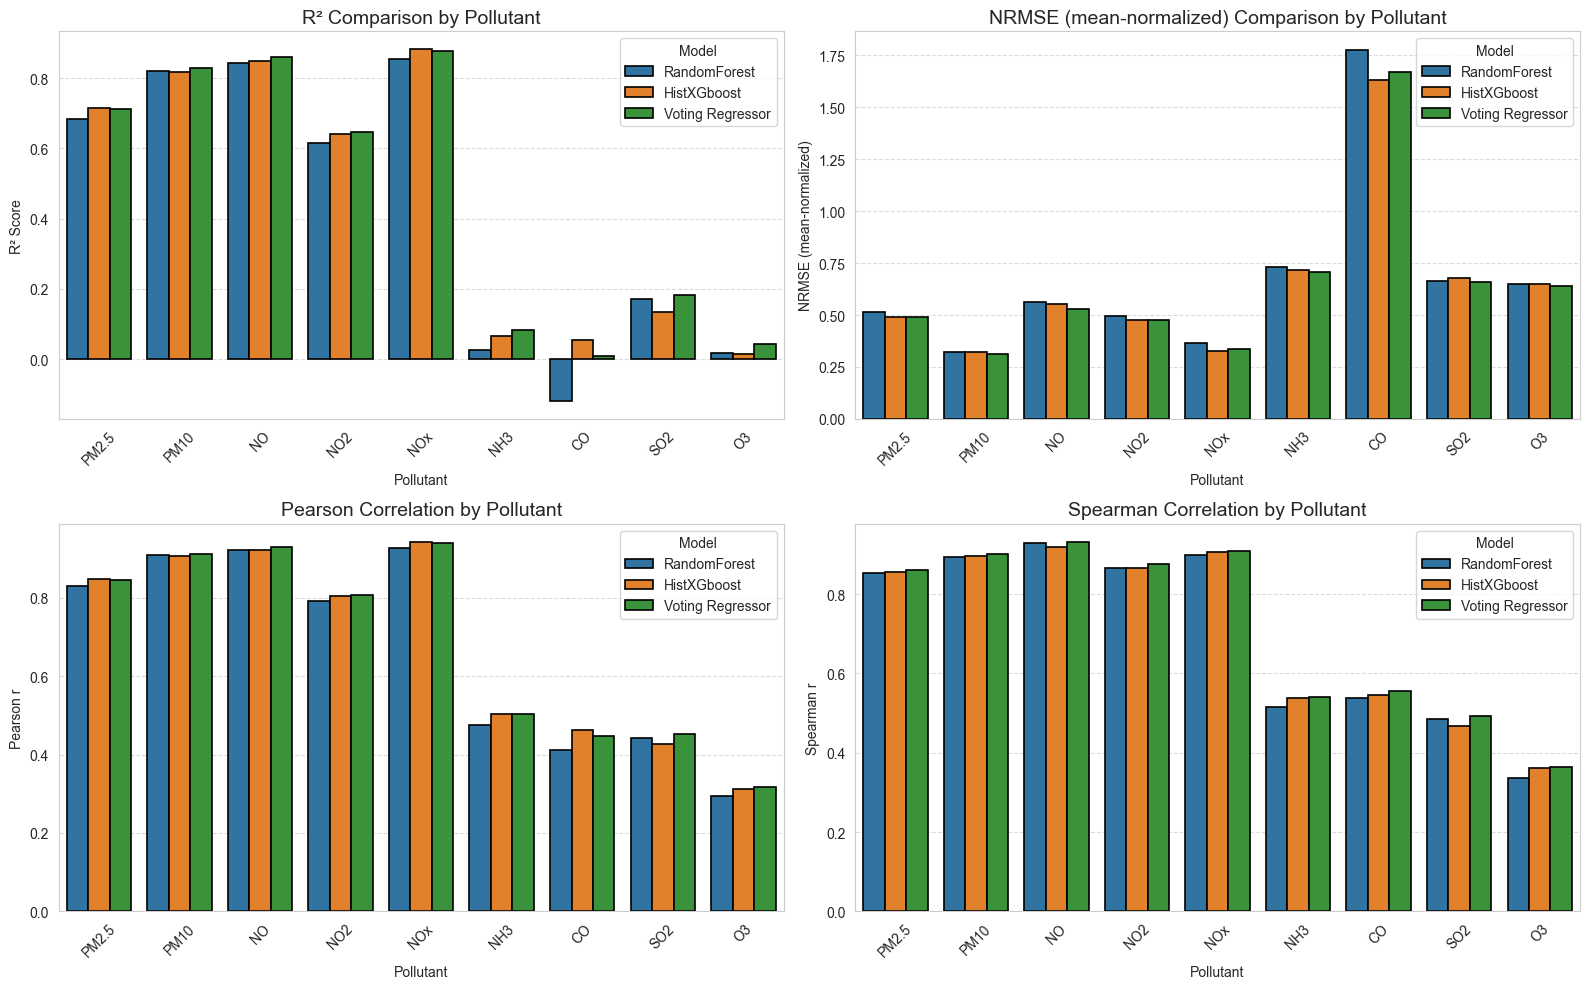

In [19]:
# use all features
all_pollutant_results_df = all_pollutant(df, all_feature_columns)

In [97]:
all_pollutant_results_df.to_csv('all_pollutant_results_df.csv', index= False)

In [98]:
def all_pollutant_cv(df, features, subsection=None, n_simulations=5):
    """
    Run multiple independent simulations (random splits each time)
    for each pollutant using custom preprocess functions.
    """

    pollutants = [
        'PM2.5','PM10', 'NO', 'NO2', 'NOx', 'NH3',
        'CO', 'SO2', 'O3', 'Benzene','Toluene','Xylene'
    ]

    results_df = pd.DataFrame(columns=[
        'Pollutant', 'Model',
        'R2_mean', 'R2_std',
        'RMSE_mean', 'RMSE_std',
        'NRMSE_mean', 'NRMSE_std',
        'Pearson_mean', 'Spearman_mean'
    ])

    for target_pollutant in pollutants:
        print(f"Running {n_simulations} simulations for pollutant: {target_pollutant}")

        X_features = [col for col in features if col != target_pollutant]

        # Collect metrics across simulations
        sim_metrics = {
            'RandomForest': {'r2': [], 'rmse': [], 'nrmse': [], 'pearson': [], 'spearman': []},
            'HistXGBoost': {'r2': [], 'rmse': [], 'nrmse': [], 'pearson': [], 'spearman': []},
            'Voting Regressor': {'r2': [], 'rmse': [], 'nrmse': [], 'pearson': [], 'spearman': []}
        }

        for sim in range(1, n_simulations + 1):
            print(f"  Simulation {sim}/{n_simulations}...")

            # Call your existing preprocessing function
            if subsection is None:
                X_train, X_test, y_train, y_test, y_scaler = preprocess(
                    df, features, target_pollutant
                )
            else:
                X_train, X_test, y_train, y_test, y_scaler = preprocess_subset(
                    df, features, target_pollutant, subset_size=subsection
                )

            # --- Random Forest ---
            rf_model, rf_y_pred, r2_rf, rmse_rf, nrmse_rf, pearson_rf, spearman_rf = random_forest(
                X_train, X_test, y_train, y_test,
                feature_columns=X_features, print_res=False, plot_graphs=False
            )

            # --- XGBoost ---
            xgb_model, xgb_y_pred, r2_xgb, rmse_xgb, nrmse_xgb, pearson_xgb, spearman_xgb = hxg_boost(
                X_train, X_test, y_train, y_test,
                selected_features=X_features, print_res=False, plot_graphs=False
            )

            # --- Voting Regressor ---
            voting_y_pred, r2_vote, rmse_vote, nrmse_vote, pearson_vote, spearman_vote = voting_reg(
                X_test, X_test, y_test, rf_model, xgb_model, print_res=False
            )

            # Store results for each simulation
            sim_metrics['RandomForest']['r2'].append(r2_rf)
            sim_metrics['RandomForest']['rmse'].append(rmse_rf)
            sim_metrics['RandomForest']['nrmse'].append(nrmse_rf)
            sim_metrics['RandomForest']['pearson'].append(pearson_rf)
            sim_metrics['RandomForest']['spearman'].append(spearman_rf)

            sim_metrics['HistXGBoost']['r2'].append(r2_xgb)
            sim_metrics['HistXGBoost']['rmse'].append(rmse_xgb)
            sim_metrics['HistXGBoost']['nrmse'].append(nrmse_xgb)
            sim_metrics['HistXGBoost']['pearson'].append(pearson_xgb)
            sim_metrics['HistXGBoost']['spearman'].append(spearman_xgb)

            sim_metrics['Voting Regressor']['r2'].append(r2_vote)
            sim_metrics['Voting Regressor']['rmse'].append(rmse_vote)
            sim_metrics['Voting Regressor']['nrmse'].append(nrmse_vote)
            sim_metrics['Voting Regressor']['pearson'].append(pearson_vote)
            sim_metrics['Voting Regressor']['spearman'].append(spearman_vote)

        # Aggregate results across simulations
        for model_name, vals in sim_metrics.items():
            results_df.loc[len(results_df)] = [
                target_pollutant, model_name,
                np.mean(vals['r2']), np.std(vals['r2']),
                np.mean(vals['rmse']), np.std(vals['rmse']),
                np.mean(vals['nrmse']), np.std(vals['nrmse']),
                np.mean(vals['pearson']), np.mean(vals['spearman'])
            ]

    # --- Visualization with error bars ---
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()

    # R² plot
    sns.barplot(
        data=results_df, x='Pollutant', y='R2_mean', hue='Model',
        ax=axes[0], edgecolor='black', linewidth=1.2,
        errorbar=None
    )
    for i, bar in enumerate(axes[0].containers):
        for patch, (_, row) in zip(bar, results_df[results_df['Model'] == bar.get_label()].iterrows()):
            axes[0].errorbar(
                patch.get_x() + patch.get_width()/2, row['R2_mean'],
                yerr=row['R2_std'], fmt='none', ecolor='black', capsize=3, lw=1
            )
    axes[0].set_title('R² across simulations ± std')
    axes[0].tick_params(axis='x', rotation=45)

    # NRMSE plot
    sns.barplot(
        data=results_df, x='Pollutant', y='NRMSE_mean', hue='Model',
        ax=axes[1], edgecolor='black', linewidth=1.2,
        errorbar=None
    )
    for i, bar in enumerate(axes[1].containers):
        for patch, (_, row) in zip(bar, results_df[results_df['Model'] == bar.get_label()].iterrows()):
            axes[1].errorbar(
                patch.get_x() + patch.get_width()/2, row['NRMSE_mean'],
                yerr=row['NRMSE_std'], fmt='none', ecolor='black', capsize=3, lw=1
            )
    axes[1].set_title('NRMSE across simulations ± std')
    axes[1].tick_params(axis='x', rotation=45)

    # Pearson plot
    sns.barplot(
        data=results_df, x='Pollutant', y='Pearson_mean', hue='Model',
        ax=axes[2], edgecolor='black', linewidth=1.2,
        errorbar=None
    )
    axes[2].set_title('Pearson correlation (mean ± std)')
    axes[2].tick_params(axis='x', rotation=45)

    # Spearman plot
    sns.barplot(
        data=results_df, x='Pollutant', y='Spearman_mean', hue='Model',
        ax=axes[3], edgecolor='black', linewidth=1.2,
        errorbar=None
    )
    axes[3].set_title('Spearman correlation (mean ± std)')
    axes[3].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return results_df


Running 5 simulations for pollutant: PM2.5
  Simulation 1/5...
  Simulation 2/5...
  Simulation 3/5...
  Simulation 4/5...
  Simulation 5/5...
Running 5 simulations for pollutant: PM10
  Simulation 1/5...
  Simulation 2/5...
  Simulation 3/5...
  Simulation 4/5...
  Simulation 5/5...
Running 5 simulations for pollutant: NO
  Simulation 1/5...
  Simulation 2/5...
  Simulation 3/5...
  Simulation 4/5...
  Simulation 5/5...
Running 5 simulations for pollutant: NO2
  Simulation 1/5...
  Simulation 2/5...
  Simulation 3/5...
  Simulation 4/5...
  Simulation 5/5...
Running 5 simulations for pollutant: NOx
  Simulation 1/5...
  Simulation 2/5...
  Simulation 3/5...
  Simulation 4/5...
  Simulation 5/5...
Running 5 simulations for pollutant: NH3
  Simulation 1/5...
  Simulation 2/5...
  Simulation 3/5...
  Simulation 4/5...
  Simulation 5/5...
Running 5 simulations for pollutant: CO
  Simulation 1/5...
  Simulation 2/5...
  Simulation 3/5...
  Simulation 4/5...
  Simulation 5/5...
Running 5 si

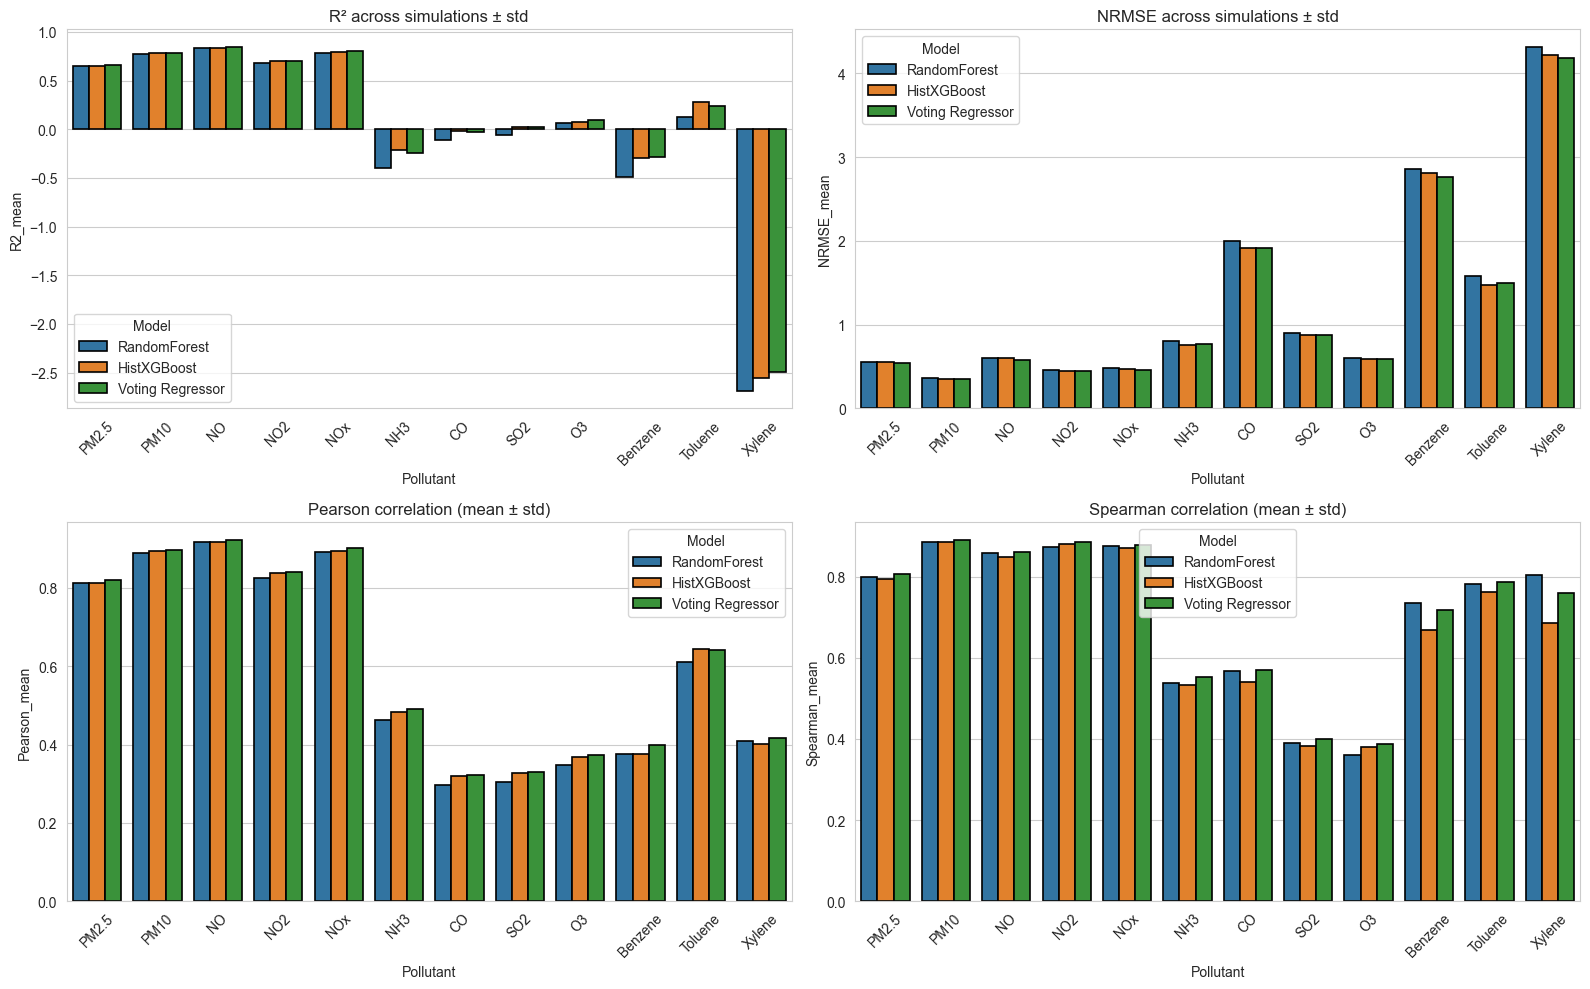

In [99]:
all_pollutant_cv_df = all_pollutant_cv(df, all_feature_columns)

In [100]:
all_pollutant_cv_df.to_csv('all_pollutant_cv_results_df.csv', index= False)

Full pipeline for a pollutant.

In [17]:
def full_pipeline(df, target_pollutant, feature_columns, subsection = None):

    # -----------------------------------------------------------------------------------------------
    # Split data into train and test
    print('Splitting Dataset')
    # get target feature
    X_features = [col for col in feature_columns if col != target_pollutant]

    if subsection == None:
        # Change target polluatant if wanting to predict for different pollutant.
        X_train, X_test, y_train, y_test, y_scaler = preprocess(df, feature_columns, target_pollutant)

    else:
        X_train, X_test, y_train, y_test, y_scaler = preprocess_subset(df, feature_columns, target_pollutant, subset_size= subsection)

    # ------------------------------------------------------------------------------------------------
    # feature optimisation 

    print('Feature optimisation for Random Forest:')
    optimal_features_rf = custom_rfecv_rf(X_train, y_train, step=1, cv=5)
    print('Feature optimisation for HXGB')
    optimal_features_xgb = custom_rfecv_xgb(X_train, y_train, X_features, step=1, cv=5, target_pollutant= target_pollutant)

    # Need to ensure station is still tracked
    optimal_features_rf.append('stationid_int', 'datetime')
    optimal_features_xgb.append('stationid_int','datetime')
    X_train_rf, X_test_rf = X_train[optimal_features_rf], X_test[optimal_features_rf]
    X_train_xgb, X_test_xgb = X_train[optimal_features_xgb],  X_test[optimal_features_xgb]

    # ------------------------------------------------------------------------------------------------
    # Grid search parmeters for selected features to predict with
    print('Grid searching best parameters for Random Forest:')
    best_params_rf, best_model_rf = random_forest_grid_search(X_train_rf, X_test_rf, y_train, y_test)
    print('Grid searching best parameters for HXGB')
    best_params_xgb, best_model_xgb = xgb_grid_search(X_train_xgb, X_test_xgb, y_train, y_test)
    

    #-------------------------------------------------------------------------------------------------
    # predicting with optimised models

    print('Predicting with optimised models:')
    results_df = pd.DataFrame(columns=['Pollutant', 'Model', 'R2', 'RMSE', 'NRMSE', 'Pearson Corr', 'Spearman Corr'])


    rf_model, rf_y_pred, r2_rf, rmse_rf, nrmse_rf, pearson_rf, spearman_rf = random_forest(X_train_rf, X_test_rf, y_train, y_test,
                                            feature_columns= optimal_features_rf, print_res = True, plot_graphs = True, regr = best_model_rf, target_pollutant = target_pollutant) 

    results_df.loc[len(results_df)] = [target_pollutant, 'RandomForest', r2_rf, rmse_rf, nrmse_rf, pearson_rf, spearman_rf]

    xgb_model, xgb_y_pred, r2_xgb, rmse_xgb, nrmse_xgb, pearson_xgb, spearman_xgb = hxg_boost(X_train_xgb,  X_test_xgb, y_train, y_test, selected_features= optimal_features_xgb,
                                                                                   print_res= True, plot_graphs = True, optim_model = best_model_xgb, target_pollutant = target_pollutant) 

    results_df.loc[len(results_df)] = [target_pollutant, 'HistXGboost', r2_xgb, rmse_xgb, nrmse_xgb, pearson_xgb, spearman_xgb]

    voting_y_pred, r2_vote, rmse_vote, nrmse_vote, pearson_vote, spearman_vote = voting_reg(X_test_rf, X_test_xgb, y_test, best_model_rf, best_model_xgb, print_res = False)
    
    results_df.loc[len(results_df)] = [target_pollutant, 'Voting Regressor', r2_vote, rmse_vote, nrmse_vote, pearson_vote, spearman_vote]


    # ------------------------------------------------------------------------------------------------------------------------------
    # plotting results

    sns.set_style("whitegrid")

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()  # flatten 2D axes array for easy indexing

    # --- R² Plot ---
    sns.barplot(data=results_df, x='Pollutant', y='R2', hue='Model', ax=axes[0],
                edgecolor='black', linewidth=1.2)
    axes[0].set_title(f'R² for {target_pollutant} by Regression Model', fontsize=14)
    axes[0].set_ylabel('R² Score')
    axes[0].set_xlabel('Pollutant')
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].legend(title='Model')

    # --- NRMSE Plot ---
    sns.barplot(data=results_df, x='Pollutant', y='RMSE', hue='Model', ax=axes[1],
                edgecolor='black', linewidth=1.2)
    axes[1].set_title(f'RMSE for {target_pollutant} by Regression Model', fontsize=14)
    axes[1].set_ylabel('RMSE')
    axes[1].set_xlabel('Pollutant')
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].legend(title='Model')

    # --- Pearson r Plot ---
    sns.barplot(data=results_df, x='Pollutant', y='Pearson Corr', hue='Model', ax=axes[2],
                edgecolor='black', linewidth=1.2)
    axes[2].set_title(f'Pearson Correlation for {target_pollutant} by Regression Model', fontsize=14)
    axes[2].set_ylabel('Pearson r')
    axes[2].set_xlabel('Pollutant')
    axes[2].grid(axis='y', linestyle='--', alpha=0.7)
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].legend(title='Model')

    # --- Spearman r Plot ---
    sns.barplot(data=results_df, x='Pollutant', y='Spearman Corr', hue='Model', ax=axes[3],
                edgecolor='black', linewidth=1.2)
    axes[3].set_title(f'Spearman Correlation for {target_pollutant} by Regression Model', fontsize=14)
    axes[3].set_ylabel('Spearman r')
    axes[3].set_xlabel('Pollutant')
    axes[3].grid(axis='y', linestyle='--', alpha=0.7)
    axes[3].tick_params(axis='x', rotation=45)
    axes[3].legend(title='Model')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

    # --------------------------------------------------------------------------------------------------------------------------------
    
    random_station = np.random.choice(X_test['stationid_int'].unique())

    mask = X_test['stationid_int'] == random_station
    X_test_station = X_test.loc[mask]
    y_test_station = y_test[mask.values]
    rf_y_pred_station = rf_y_pred[mask.values]
    xgb_y_pred_station = xgb_y_pred[mask.values]
    voting_y_pred_station = voting_y_pred[mask.values]

    plt.figure(figsize=(8, 5))
    plt.plot(X_test_station['datetime'][-100:], y_test_station[-100:], label=f'Actual {target_pollutant}')
    plt.plot(X_test_station['datetime'][-100:], rf_y_pred_station[-100:], label=f'RF Prediction', alpha=0.7, linestyle='--')
    plt.plot(X_test_station['datetime'][-100:], xgb_y_pred_station[-100:], label=f'XGB Prediction', alpha=0.7,linestyle='--')
    plt.plot(X_test_station['datetime'][-100:], voting_y_pred_station[-100:], label=f'Voting Prediction', alpha=0.7, linestyle='--')
    plt.xlabel("Date")
    plt.ylabel(f"{target_pollutant} Levels")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.title(f'Prediction of {target_pollutant} at Random Test Station {random_station}')
    plt.savefig('Timeseries_predicion_pipline.png')
    plt.show()

    return best_model_rf, optimal_features_rf,  best_model_xgb, optimal_features_xgb, results_df
    
# use all features
optimal_rf_model, optimal_features_rf, optimal_xgb_model, optimal_features_xgb, optimisation_results_df = full_pipeline(df, 'NOx', all_feature_columns)

optimisation_results_df.to_csv('Results_NOx_weather.csv', index = False)


Splitting Dataset
Feature optimisation for Random Forest:
Testing with 16 pollutants as features


KeyboardInterrupt: 

In [15]:
def all_stations_results_hist(df, all_feature_columns, target_pol='O3', n_splits=5):
    # -------------------------------------------------------------------------
    # 1️⃣ Station-based data splitting into fixed folds
    # -------------------------------------------------------------------------
    def data_splitting_fixed_folds(df, X_feature_columns, target_pollutant='O3', n_splits=5, seed=42):
        df_split = df.copy()
        stations = df['stationid_int'].unique()

        rng = np.random.default_rng(seed)
        rng.shuffle(stations)

        station_folds = np.array_split(stations, n_splits)
        folds = []

        for i in range(n_splits):
            test_stations = station_folds[i]
            train_stations = np.concatenate([station_folds[j] for j in range(n_splits) if j != i])

            train_set = df_split[df_split['stationid_int'].isin(train_stations)]
            test_set = df_split[df_split['stationid_int'].isin(test_stations)]

            X_train, X_test = train_set[X_feature_columns], test_set[X_feature_columns]
            y_train, y_test = train_set[target_pollutant], test_set[target_pollutant]

            folds.append((X_train, X_test, y_train, y_test))
        return folds

    # -------------------------------------------------------------------------
    # 2️⃣ Preprocessing (drop NaNs, remove outliers, optionally scale)
    # -------------------------------------------------------------------------
    def preprocess_folds(df, feature_columns, target_pollutant='O3', scaler=False, n_splits=5):
        X_features = [col for col in feature_columns if col != target_pollutant]
        df_no_Na = df.dropna(subset=[target_pollutant])
        df_clean = removing_outlier_in_target(df_no_Na, target_pollutant)

        if scaler:
            df_norm, scaler_y = norm(df_clean, X_features, target_pollutant)
        else:
            df_norm, scaler_y = df_clean, None

        folds = data_splitting_fixed_folds(df_norm, X_features, target_pollutant, n_splits)
        return folds

    # -------------------------------------------------------------------------
    # 3️⃣ Cross-validation across station folds
    # -------------------------------------------------------------------------
    folds = preprocess_folds(df, all_feature_columns, target_pol)
    all_results_rf, all_results_xgb = [], []

    for fold_idx, (X_train, X_test, y_train, y_test) in enumerate(folds, 1):
        print(f"\n--- Fold {fold_idx}/{n_splits} ---")
        print(f"Testing on {len(X_test['stationid_int'].unique())} stations")

        X_features = [col for col in all_feature_columns if col != target_pol]

        # --- Random Forest ---
        rf_model, rf_y_pred, *_ = random_forest(
            X_train, X_test, y_train, y_test,
            feature_columns=X_features, print_res=False, plot_graphs=False
        )
        fold_rf = pd.DataFrame({
            'stationid_int': X_test['stationid_int'].values,
            'y_true': y_test.values,
            'y_pred': rf_y_pred,
            'model': 'RandomForest',
            'year': X_test['year'].values,
            'month': X_test['month'].values,
            'day': X_test['day'].values
        })
        all_results_rf.append(fold_rf)

        # --- XGBoost ---
        xgb_model, xgb_y_pred, *_ = hxg_boost(
            X_train, X_test, y_train, y_test,
            selected_features=X_features, print_res=False, plot_graphs=False
        )
        fold_xgb = pd.DataFrame({
            'stationid_int': X_test['stationid_int'].values,
            'y_true': y_test.values,
            'y_pred': xgb_y_pred,
            'model': 'XGBoost',
            'year': X_test['year'].values,
            'month': X_test['month'].values,
            'day': X_test['day'].values
        })
        all_results_xgb.append(fold_xgb)

    # -------------------------------------------------------------------------
    # 4️⃣ Combine all folds and compute per-station R²
    # -------------------------------------------------------------------------
    df_results = pd.concat(all_results_rf + all_results_xgb, ignore_index=True)

    station_r2 = (
        df_results.groupby(['model', 'stationid_int'], group_keys=False)
        .apply(lambda g: r2_score(g['y_true'], g['y_pred']), include_groups=False)
        .reset_index(name='R2')
    )

    overall_r2 = (
        df_results.groupby('model')
        .apply(lambda g: r2_score(g['y_true'], g['y_pred']), include_groups=False)
    )

    print("\n✅ Overall R² per model:")
    print(overall_r2)

    # -------------------------------------------------------------------------
    # 5️⃣ Plot histograms of station-wise R²
    # -------------------------------------------------------------------------
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    models = ['RandomForest', 'XGBoost']
    colors = ['#4C72B0', '#55A868']

    for ax, model, color in zip(axes, models, colors):
        model_r2 = station_r2[station_r2['model'] == model]['R2']
        overall = overall_r2[model]

        ax.hist(model_r2, bins=20, color=color, edgecolor='white', alpha=0.85, rwidth=0.9)
        ax.axvline(overall, color='red', linestyle='--', linewidth=2, label=f'Overall = {overall:.2f}')
        ax.set_title(f"{model}: Station-wise R² Distribution", fontsize=14, weight='bold', pad=10)
        ax.set_xlabel("R² Score", fontsize=12)
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        ax.legend()

    axes[0].set_ylabel("Number of Stations", fontsize=12)
    plt.tight_layout()
    plt.show()

    # -------------------------------------------------------------------------
    # 6️⃣ Print 10 best and 10 worst stations for each model
    # -------------------------------------------------------------------------
    for model in models:
        print(f"\n📈 Top 10 Stations for {model}:")
        print(station_r2[station_r2['model'] == model].sort_values('R2', ascending=False).head(10))

        print(f"\n📉 Worst 10 Stations for {model}:")
        print(station_r2[station_r2['model'] == model].sort_values('R2', ascending=True).head(10))

    # -------------------------------------------------------------------------
    # 7️⃣ Plot time series for the *worst-performing* station of each model
    # -------------------------------------------------------------------------
    worst_stations = (
        station_r2.sort_values(by='R2')
        .groupby('model', as_index=False)
        .first()
    )

    print("\n🔍 Worst-performing stations by model:")
    print(worst_stations)

    for _, row in worst_stations.iterrows():
        model = row['model']
        station_id = row['stationid_int']
        r2_val = row['R2']

        df_station = df_results[
            (df_results['model'] == model) &
            (df_results['stationid_int'] == station_id)
        ].copy()


        plt.figure(figsize=(10, 5))
        plt.plot(df_station['datetime'], df_station['y_true'], label='Actual', color='black')
        plt.plot(df_station['datetime'], df_station['y_pred'], label=f'{model} Prediction', linestyle='--', alpha=0.75)
        plt.xlabel("Date")
        plt.ylabel(f"{target_pol} Levels")
        plt.grid(alpha=0.3)
        plt.legend()
        plt.title(f"{model}: {target_pol} at Worst Station {station_id} (R² = {r2_val:.2f})")
        plt.tight_layout()
        plt.show()

    return df_results, station_r2, overall_r2



--- Fold 1/5 ---
Testing on 21 stations

--- Fold 2/5 ---
Testing on 21 stations

--- Fold 3/5 ---
Testing on 21 stations

--- Fold 4/5 ---
Testing on 21 stations

--- Fold 5/5 ---
Testing on 21 stations

✅ Overall R² per model:
model
RandomForest    0.821023
XGBoost         0.846429
dtype: float64


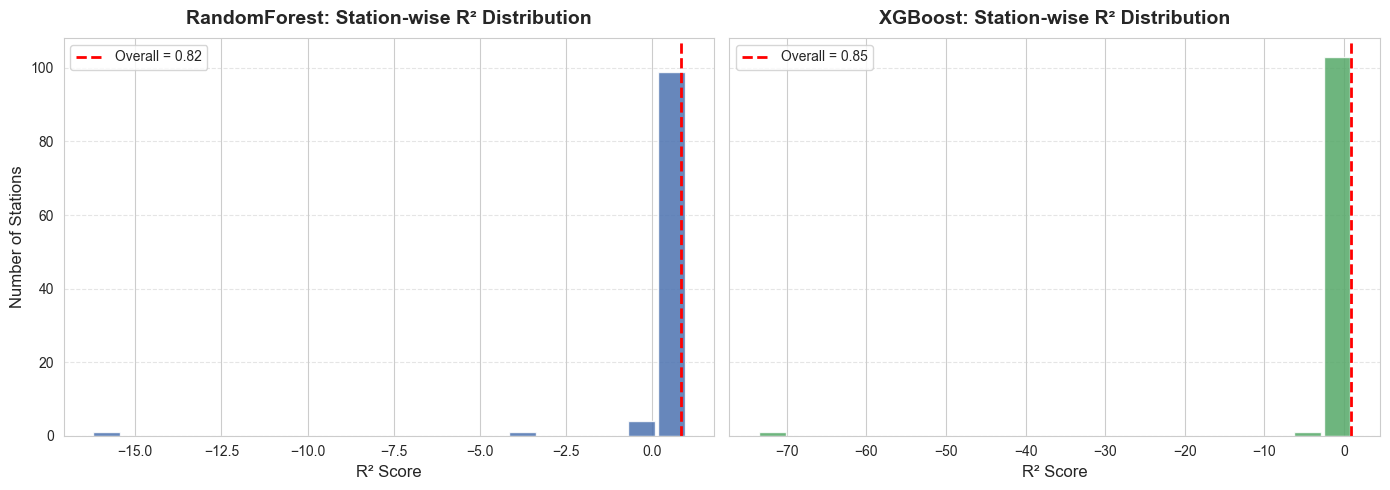


📈 Top 10 Stations for RandomForest:
           model  stationid_int        R2
35  RandomForest             38  0.985010
29  RandomForest             32  0.983291
32  RandomForest             35  0.981893
42  RandomForest             45  0.981685
26  RandomForest             29  0.980357
43  RandomForest             46  0.978957
94  RandomForest             99  0.978004
17  RandomForest             19  0.968979
12  RandomForest             14  0.964752
10  RandomForest             12  0.963881

📉 Worst 10 Stations for RandomForest:
           model  stationid_int         R2
73  RandomForest             78 -16.266785
91  RandomForest             96  -3.952276
3   RandomForest              3  -0.654798
48  RandomForest             51  -0.353855
63  RandomForest             68  -0.173684
75  RandomForest             80   0.104613
92  RandomForest             97   0.264107
53  RandomForest             57   0.350868
56  RandomForest             61   0.381878
57  RandomForest             62 

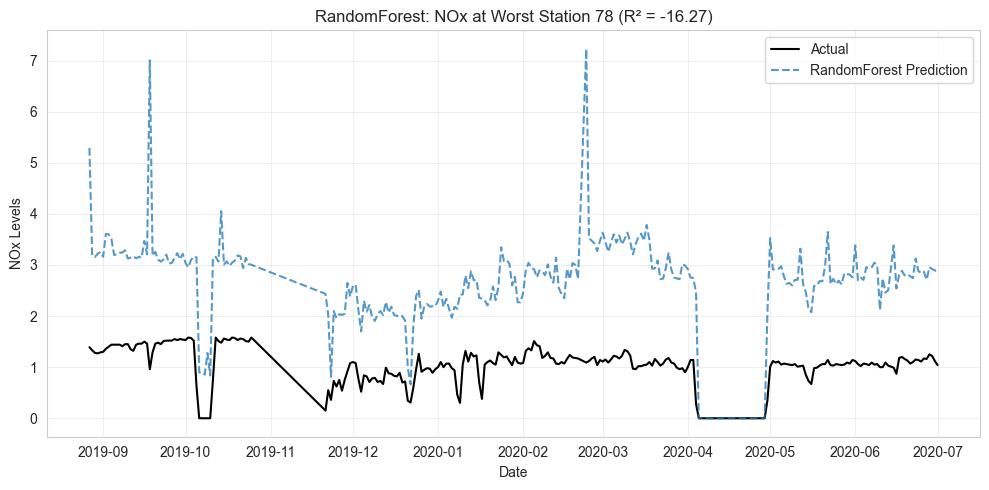

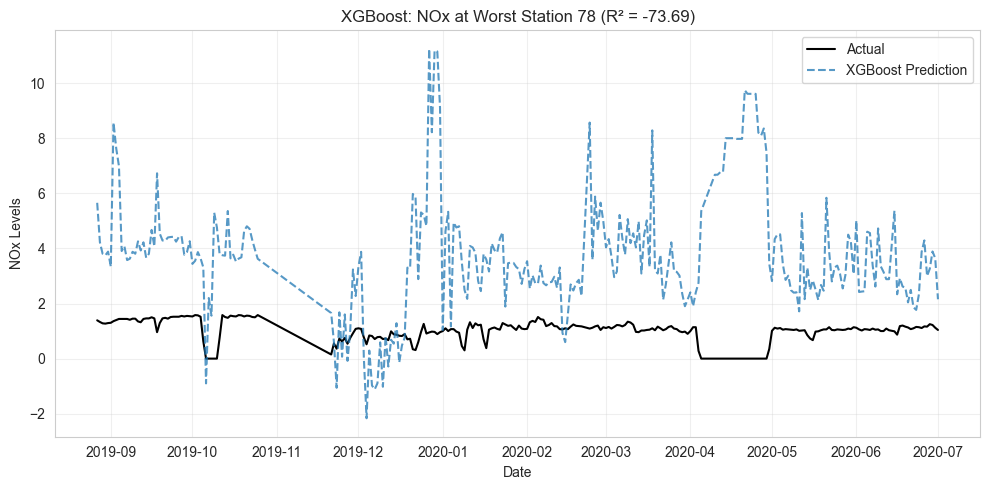

In [141]:
hist_results, hist_res_r2, hist_res_overall_r2 = all_stations_results_hist(df, all_feature_columns, 'NOx')


--- Fold 1/5 ---
Testing on 21 stations

--- Fold 2/5 ---
Testing on 21 stations

--- Fold 3/5 ---
Testing on 21 stations

--- Fold 4/5 ---
Testing on 21 stations

--- Fold 5/5 ---
Testing on 21 stations

Overall R² per model:
model
RandomForest    0.821023
XGBoost         0.846429
dtype: float64


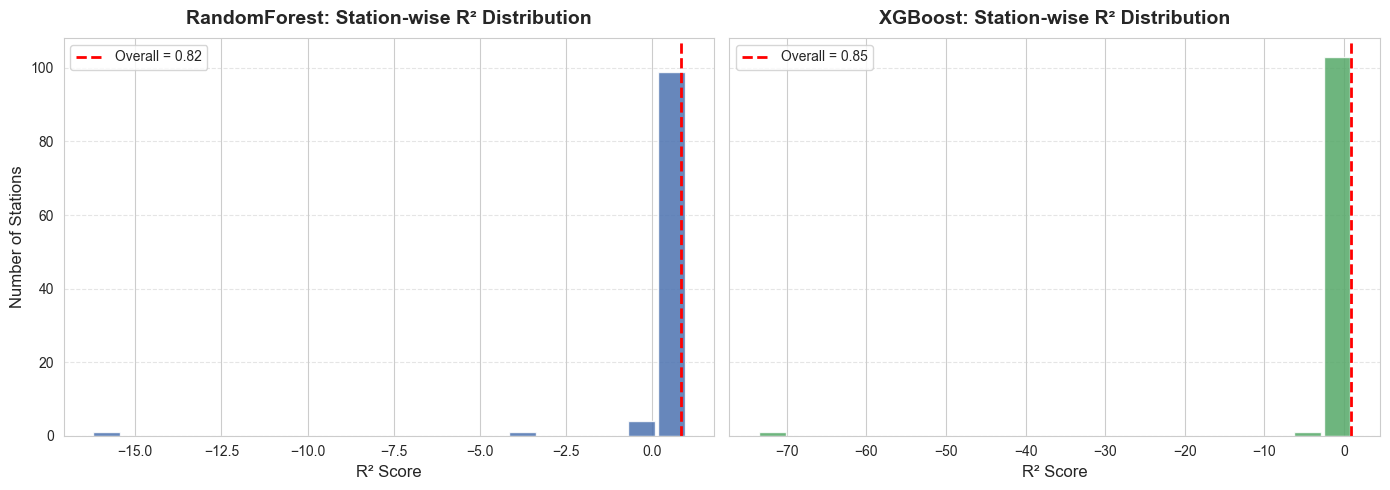

In [117]:
def all_stations_results_hist(df, all_feature_columns, target_pol = 'O3', n_splits = 5):

    
    def data_splitting_fixed_folds(df, X_feature_columns, target_pollutant='O3', n_splits=5, seed=42):
        """
        Split dataset into fixed station-based folds (no overlap between stations).

        Returns:
            folds: list of (X_train, X_test, y_train, y_test) tuples for each fold
        """

        df_split = df.copy()
        stations = df['stationid_int'].unique()
        
        # Fix the random seed for reproducibility
        rng = np.random.default_rng(seed)
        rng.shuffle(stations)

        # Split station list into n_splits nearly equal parts
        station_folds = np.array_split(stations, n_splits)

        folds = []
        for i in range(n_splits):
            test_stations = station_folds[i]
            train_stations = np.concatenate([station_folds[j] for j in range(n_splits) if j != i])

            train_set = df_split[df_split['stationid_int'].isin(train_stations)]
            test_set = df_split[df_split['stationid_int'].isin(test_stations)]

            X_train, X_test = train_set[X_feature_columns], test_set[X_feature_columns]
            y_train, y_test = train_set[target_pollutant], test_set[target_pollutant]

            folds.append((X_train, X_test, y_train, y_test))

        return folds


    def preprocess_folds(df, feature_columns, target_pollutant = 'O3', scaler = False, n_splits = 5):

        X_features = [col for col in feature_columns if col != target_pollutant]
        
        # Remove rows where target variable (O3) is missing
        df_no_Na = df.dropna(subset=[target_pollutant])

        df_clean = removing_outlier_in_target(df_no_Na, target_pollutant)

        if scaler == True:
            # normaise fatures
            df_norm, scaler_y = norm(df_clean, X_features, target_pollutant)
        else:
            df_norm = df_clean
            scaler_y = None

        # split data into train and test sets based on stations
        folds = data_splitting_fixed_folds(df_norm, X_features, target_pollutant, n_splits)

        return folds


    folds = preprocess_folds(df, all_feature_columns, target_pol)

    all_results_rf = []
    all_results_xgb = []

    for fold_idx, (X_train, X_test, y_train, y_test) in enumerate(folds, 1):
        print(f"\n--- Fold {fold_idx}/{n_splits} ---")
        print(f"Testing on {len(X_test['stationid_int'].unique())} stations")

        X_features = [col for col in all_feature_columns if col != target_pol]

        # --- Random Forest ---
        rf_model, rf_y_pred, r2_rf, rmse_rf, nrmse_rf, pearson_rf, spearman_rf = random_forest(
            X_train, X_test, y_train, y_test,
            feature_columns=X_features, print_res=False, plot_graphs=False
        )

        fold_rf = pd.DataFrame({
            'stationid_int': X_test['stationid_int'].values,
            'y_true': y_test.values,
            'y_pred': rf_y_pred,
            'model': 'RandomForest'
        })
        all_results_rf.append(fold_rf)

        # --- XGBoost ---
        xgb_model, xgb_y_pred, r2_xgb, rmse_xgb, nrmse_xgb, pearson_xgb, spearman_xgb = hxg_boost(
            X_train, X_test, y_train, y_test,
            selected_features=X_features, print_res=False, plot_graphs=False
        )

        fold_xgb = pd.DataFrame({
            'stationid_int': X_test['stationid_int'].values,
            'y_true': y_test.values,
            'y_pred': xgb_y_pred,
            'model': 'XGBoost'
        })
        all_results_xgb.append(fold_xgb)

    # --- Combine all folds ---
    df_results = pd.concat(all_results_rf + all_results_xgb, ignore_index=True)

    # --- Compute per-station R² for each model ---
    station_r2 = (
        df_results.groupby(['model', 'stationid_int'], group_keys=False)
        .apply(lambda g: r2_score(g['y_true'], g['y_pred']), include_groups=False)
        .reset_index(name='R2')
    )

    # --- Overall R² per model ---
    overall_r2 = (
        df_results.groupby('model')
        .apply(lambda g: r2_score(g['y_true'], g['y_pred']), include_groups=False)
    )

    print("\nOverall R² per model:")
    print(overall_r2)

    # --- Plot side-by-side histograms ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    models = ['RandomForest', 'XGBoost']
    colors = ['#4C72B0', '#55A868']

    for ax, model, color in zip(axes, models, colors):
        model_r2 = station_r2[station_r2['model'] == model]['R2']
        overall = overall_r2[model]

        n, bins, patches = ax.hist(
            model_r2,
            bins=20,
            color=color,
            edgecolor='white',
            alpha=0.85,
            rwidth=0.9
        )

        ax.axvline(overall, color='red', linestyle='--', linewidth=2, label=f'Overall = {overall:.2f}')
        ax.set_title(f"{model}: Station-wise R² Distribution", fontsize=14, weight='bold', pad=10)
        ax.set_xlabel("R² Score", fontsize=12)
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        ax.legend()

    axes[0].set_ylabel("Number of Stations", fontsize=12)
    plt.tight_layout()
    plt.show()

    return df_results, station_r2, overall_r2

hist_results, hist_res_r2, hist_res_overall_r2 = all_stations_results_hist(df, all_feature_columns, 'NOx')

In [118]:
# --- Top & Bottom 10 stations per model ---
for model in hist_res_r2['model'].unique():
    print(f"\n===== {model} =====")

    model_r2 = hist_res_r2[hist_res_r2['model'] == model].copy()
    model_r2_sorted = model_r2.sort_values(by='R2', ascending=False)

    print("\nTop 10 stations by R²:")
    print(model_r2_sorted.head(10).to_string(index=False))

    print("\nBottom 10 stations by R²:")
    print(model_r2_sorted.tail(10).to_string(index=False))



===== RandomForest =====

Top 10 stations by R²:
       model  stationid_int       R2
RandomForest             38 0.985010
RandomForest             32 0.983291
RandomForest             35 0.981893
RandomForest             45 0.981685
RandomForest             29 0.980357
RandomForest             46 0.978957
RandomForest             99 0.978004
RandomForest             19 0.968979
RandomForest             14 0.964752
RandomForest             12 0.963881

Bottom 10 stations by R²:
       model  stationid_int         R2
RandomForest             62   0.400135
RandomForest             61   0.381878
RandomForest             57   0.350868
RandomForest             97   0.264107
RandomForest             80   0.104613
RandomForest             68  -0.173684
RandomForest             51  -0.353855
RandomForest              3  -0.654798
RandomForest             96  -3.952276
RandomForest             78 -16.266785

===== XGBoost =====

Top 10 stations by R²:
  model  stationid_int       R2
XGBoost   

### comparing results

Comparing prediction performance with removal of correlated features to see if model can still perform

In [116]:
#correlation_matrix(df)

Removing one of the two features that have correlation greater than 0.8. 

The removed feature will be based on the one with fewer NaN values.

In [106]:
def corr_features_to_remove(df, threshold_corr = 0.8, target_pollutant = 'O3', print_res = False):

    # list of pollutants
    pollutants = ['PM2.5','PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']

    # getting corralation
    corr = df[pollutants].corr()

    # 2. Keep only upper triangle (exclude diagonal & duplicates)

    corr = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    corr = corr[corr >= threshold_corr]

    # 3. Flatten into long form (pairs + correlation value)
    corr_pairs = (
        corr.stack()  # removes NaN automatically
        .reset_index()
    )
    corr_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']
    
    feature_to_remove_by_Nan = []
    feature_to_remove_by_target_corr = []

    # iterate through pairs of highly correlated features
    for pair in corr_pairs.index:

        f1, f2 = corr_pairs.loc[pair, ['Feature_1', 'Feature_2']]

        if f1 == target_pollutant or f2 == target_pollutant:
            continue

        # Count NaN values for each feature in the original DataFrame
        nan_f1 = df[f1].isna().sum()
        nan_f2 = df[f2].isna().sum()

        # Compare which has more missing values
        if nan_f1 > nan_f2:
            if print_res == True:
                print(f"{f1} has more NaN values ({nan_f1}) than {f2} ({nan_f2}).")
            feature_to_remove_by_Nan.append(f1)
        else:
            if print_res == True:
                print(f"{f2} has more NaN values ({nan_f2}) than {f1} ({nan_f1}).")
            feature_to_remove_by_Nan.append(f2)

        # Compute correlation with target 
        corr_f1 = df[[f1, target_pollutant]].corr().iloc[0, 1]
        corr_f2 = df[[f2, target_pollutant]].corr().iloc[0, 1]

        # Compare absolute correlation with the target
        if corr_f1 > corr_f2:
            if print_res == True:
                print(f"{f2} has lower correlation ({corr_f2:.3f}) with {target_pollutant} than {f1} ({corr_f1:.3f}). Removing {f2}.")
            feature_to_remove_by_target_corr.append(f2)
        else:
            if print_res == True:
                print(f"{f1} has lower correlation ({corr_f1:.3f}) with {target_pollutant} than {f2} ({corr_f2:.3f}). Removing {f1}.")
            feature_to_remove_by_target_corr.append(f1)


    return corr_pairs, [feature_to_remove_by_Nan, feature_to_remove_by_target_corr]
    
def compare_w_removed_features(df, features, subsection = None):

    # list of pollutants
    pollutants = ['PM2.5','PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']

    results_df = pd.DataFrame(columns=['Pollutant', 'Model', 'Removal_reason', 'R2', 'RMSE', 'NRMSE', 'Pearson Corr', 'Spearman Corr'])

    for target_pollutant in pollutants:

        print(f'Predicting: {target_pollutant}')

        if subsection == None:
            # Change target polluatant if wanting to predict for different pollutant.
            X_train, X_test, y_train, y_test, y_scaler = preprocess(df, features, target_pollutant)

        else:
            X_train, X_test, y_train, y_test, y_scaler = preprocess_subset(df, features, target_pollutant, subset_size= subsection)

        # get info on highly correlated pairs 
        corr_pairs, features_to_remove = corr_features_to_remove(df, target_pollutant = target_pollutant, print_res = False)
        
        # Add a baseline "no removal" condition
        features_to_remove.insert(0, [])  
        removal_methods = ['None', 'Number of NaN', 'Corr w Target']

        for i, method in enumerate(removal_methods):
            
            remove_list = features_to_remove[i]
            
            X_features = [col for col in features 
              if col != target_pollutant and col not in remove_list]
            


            X_train_iter, X_test_iter = X_train[X_features], X_test[X_features]

            rf_model, r2_rf, rmse_rf, nrmse_rf, pearson_rf, spearman_rf = random_forest(X_train_iter, X_test_iter, y_train, y_test,
                                                feature_columns= X_features, print_res = False, plot_graphs = False) 

            results_df.loc[len(results_df)] = [target_pollutant, 'RandomForest', method, r2_rf, rmse_rf, nrmse_rf, pearson_rf, spearman_rf]

            xgb_model, r2_xgb, rmse_xgb, nrmse_xgb, pearson_xgb, spearman_xgb = hxg_boost(X_train_iter,  X_test_iter, y_train, y_test, selected_features= X_features, print_res= False, plot_graphs = False) 

            results_df.loc[len(results_df)] = [target_pollutant, 'HistXGboost', method, r2_xgb, rmse_xgb, nrmse_xgb, pearson_xgb, spearman_xgb]


            # Dont need votign regressor
            #r2_vote, rmse_vote, nrmse_vote, pearson_vote, spearman_vote = voting_reg(X_test_iter, X_test_iter, y_test, rf_model, xgb_model, print_res = False)
            
            #results_df.loc[len(results_df)] = [target_pollutant, 'Voting Regressor', method, r2_vote, rmse_vote, nrmse_vote, pearson_vote, spearman_vote]

    return results_df

#corr_pairs, feat_to_remove = corr_features_to_remove(df, print_res = True, target_pollutant= 'PM10')

# use all features
#results_remove_corr = compare_w_removed_features(df, all_feature_columns, subsection = 25)

In [107]:
def plotting_remove_corr(results_df):
    
    sns.set(style="whitegrid")

    g = sns.catplot(
        data=results_df,
        x="Pollutant",
        y="R2",
        hue="Removal_reason",
        col="Model",
        kind="bar",
        height=5,
        aspect=1.1,
        sharey=True
    )

    g.fig.set_dpi(150)
    g.set_titles("{col_name}")
    g.set_axis_labels("Pollutant", "R²")
    g.add_legend(title="Removal reason")

    plt.tight_layout()
    plt.show()

#plotting_remove_corr(results_remove_corr)
